## Preprocessing

In [1]:
!wget --header="Host: doc-0c-40-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_81hluv81adjprjfo5ucus7r4g5c0fm3t_nonce=9dagd610ub1p6" --header="Connection: keep-alive" "https://doc-0c-40-docs.googleusercontent.com/docs/securesc/qsegjfskkrpjhbbv9npr5i2j9ukntgkv/7m37sb09lddce57lo1ap43luud699p9d/1617897675000/13641879967109176128/13641879967109176128/1PbXrGTEVHfGA4XvN9_hgsVz7M1BFN1FO?e=download&authuser=1&nonce=9dagd610ub1p6&user=13641879967109176128&hash=5l5nvnnpj6sj5rjv2gbbg2te542kijim" -c -O 'icdar_comp.zip'

--2021-04-08 16:02:02--  https://doc-0c-40-docs.googleusercontent.com/docs/securesc/qsegjfskkrpjhbbv9npr5i2j9ukntgkv/7m37sb09lddce57lo1ap43luud699p9d/1617897675000/13641879967109176128/13641879967109176128/1PbXrGTEVHfGA4XvN9_hgsVz7M1BFN1FO?e=download&authuser=1&nonce=9dagd610ub1p6&user=13641879967109176128&hash=5l5nvnnpj6sj5rjv2gbbg2te542kijim
Resolving doc-0c-40-docs.googleusercontent.com (doc-0c-40-docs.googleusercontent.com)... 172.217.12.225, 2607:f8b0:4004:807::2001
Connecting to doc-0c-40-docs.googleusercontent.com (doc-0c-40-docs.googleusercontent.com)|172.217.12.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘icdar_comp.zip’

icdar_comp.zip          [           <=>      ] 173.77M  47.0MB/s    in 3.7s    

2021-04-08 16:02:06 (47.0 MB/s) - ‘icdar_comp.zip’ saved [182213372]



In [ ]:
#!unzip -x Synth_sample.zip
!unzip -x icdar_comp.zip

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import tensorflow as tf
import scipy.io as sio
#import xml.dom.minidom
import sys
import random
import time
from itertools import compress
import matplotlib.pyplot as plt
from scipy import ndimage
import glob 

import threading
import multiprocessing
try:
    import queue
except ImportError:
    import Queue as queue



### **Synthtext Conversion**

### Converting Synthtext to icdar format -> x1,y1,x2,y2,x3,y3,x4,y4,<>word in block<>
#### **run only once**

In [4]:
'''

def syth2icdar(matfile, saveFolder):
    if os.path.exists(saveFolder) is False:
        os.makedirs(saveFolder)
    data = sio.loadmat(matfile)

    for i in range(len(data['txt'][0])):
        words = []
        for val in data['txt'][0][i]:
            word_list = [x.strip().split(" ") for x in val.strip().split("\n")]
            # concatenate all of the list elements
            words.extend(sum(word_list, []))
        words = [el for el in words if el != '']
        co_ordinates = np.array(data['wordBB'][0][i], dtype=np.int32)
        if len(co_ordinates.shape) == 3:
            co_ordinates = co_ordinates.transpose(2,1,0) 
        else:
            co_ordinates = co_ordinates.transpose(1,0)[np.newaxis, :] #if there are no words in pic

        root = []
        print("start to process {} object".format(len(co_ordinates)))
        assert len(co_ordinates) == len(words), "filename {}: the length of the objects and the labels differ.".format(data['imnames'][0][i][0])

        for j in range(len(co_ordinates)):
            infos = []
            infos.append(str(int(co_ordinates[j][0][0])))
            infos.append(str(int(co_ordinates[j][0][1])))
            infos.append(str(int(co_ordinates[j][1][0])))
            infos.append(str(int(co_ordinates[j][1][1])))
            infos.append(str(int(co_ordinates[j][2][0])))
            infos.append(str(int(co_ordinates[j][2][1])))
            infos.append(str(int(co_ordinates[j][3][0])))
            infos.append(str(int(co_ordinates[j][3][1])))
            assert len(str(words[j])) != 0, "filename {}: lebel length is 0".format(data['imnames'][0][i][0])
            infos.append(str(words[j])) #x1,y1,x2,y2,x3,y3,x4,y4,<>word<>
            root.append(infos)

        filename = data['imnames'][0][i][0].replace('.jpg', '.txt')
        dir_name = os.path.dirname(filename)
        img_dir_path = os.path.join(saveFolder, dir_name)
        if not os.path.exists(img_dir_path):
            #print("created dir {}".format(dir_name))
            os.makedirs(img_dir_path, exist_ok=True)
        fp = open(os.path.join(saveFolder, filename), 'w')
        fp.write('\n'.join([','.join([i for i in j]) for j in root]))
        fp.close()

if __name__=='__main__':
    syth2icdar('SynthText/gt.mat', 'SynthText/')

'''

'\n\ndef syth2icdar(matfile, saveFolder):\n    if os.path.exists(saveFolder) is False:\n        os.makedirs(saveFolder)\n    data = sio.loadmat(matfile)\n\n    for i in range(len(data[\'txt\'][0])):\n        words = []\n        for val in data[\'txt\'][0][i]:\n            word_list = [x.strip().split(" ") for x in val.strip().split("\n")]\n            # concatenate all of the list elements\n            words.extend(sum(word_list, []))\n        words = [el for el in words if el != \'\']\n        co_ordinates = np.array(data[\'wordBB\'][0][i], dtype=np.int32)\n        if len(co_ordinates.shape) == 3:\n            co_ordinates = co_ordinates.transpose(2,1,0) \n        else:\n            co_ordinates = co_ordinates.transpose(1,0)[np.newaxis, :] #if there are no words in pic\n\n        root = []\n        print("start to process {} object".format(len(co_ordinates)))\n        assert len(co_ordinates) == len(words), "filename {}: the length of the objects and the labels differ.".format(data[\'

* Now we have all our data in same format.

**Synth Text Loader:**

In [5]:


class SynthTextLoader():
    
    def get_images(self, data_dir):
        gt_dict = {}
        gt_mat_path = os.path.join(data_dir, "gt.mat")
        gt_mat = sio.loadmat(gt_mat_path, gt_dict, squeeze_me=True, struct_as_record=False, variable_names=['imnames', 'wordBB', 'txt'])

        image_list = gt_dict['imnames']
        return image_list
    
    def label_to_array(self,label):
        #print("#######")
        CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ#()+-"
        #NUM_CLASSES = len(CHAR_VECTOR) + 1
        try:
            label = label.replace(' ', '')
            return [CHAR_VECTOR.index(x) for x in label]
        except Exception as ex:
            #print(label)
            raise ex

    def check_minus(self, polygon):  #if negative co-ordinates present then return False
        for p in polygon:
            if p < 0:
                return True
        return False
    
    def get_images_list(self, data_dir):  #get images list
       
        images_list=[]
        folders = os.listdir(data_dir)
        for folder in folders:
          images=os.listdir(data_dir+folder+"/")
          for image in images:
            if image.endswith(".jpg"):
                image_path=folder+"/"+image
                images_list.append(image_path)
        return images_list

    def load_annotation(self, gt_file):
        try:
            text_polys = []
            text_tags = []
            labels = []
            
            if not os.path.exists(gt_file):
                return np.array(text_polys, dtype=np.int32)
            with open(gt_file, 'r') as f:
                for line in f.readlines():
                    line = line.replace('\xef\xbb\bf', '')
                    line = line.replace('\xe2\x80\x8d', '')
                    line = line.strip()
                    line = line.split(',')
                    # Deal with transcription containing ,
                    if len(line) > 9:
                        label = line[8]
                        for i in range(len(line) - 9):
                            label = label + "," + line[i+9]
                    else:
                        label = line[-1]

                    # convert str to numbers(int or float)
                    temp_line = list(map(eval, line[:8]))
                    if self.check_minus(temp_line): #if any negative co-ordnitaes are present.
                        continue
                    x1, y1, x2, y2, x3, y3, x4, y4 = map(float, temp_line)

                    text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
                    text_tags.append(False)
                    #print(label)
                    label_list=self.label_to_array(label)
                    labels.append(label_list)
                    #print(label)
        except Exception as e:
            #print(e)
            print("",end="")
            #print(gt_file)

        return np.array(text_polys, dtype=np.float32), np.array(text_tags, dtype=np.bool), labels

In [ ]:
######################################################################################################
### check cell                                                                                      ##
### synthetic loader check                                                                          ##
######################################################################################################
'''

data_loader=SynthTextLoader()
poly_points,text_tags,labels=data_loader.load_annotation("SynthText/1/ant+hill_145_36.txt")

#### output ->  co-ordinates,text_tag,label
'''

'\n\ndata_loader=SynthTextLoader()\npoly_points,text_tags,labels=data_loader.load_annotation("SynthText/1/ant+hill_145_36.txt")\n\n#### output ->  co-ordinates,text_tag,label\n'

In [ ]:
######################################################################################################
### check cell                                                                                      ##
### Mask example                                                                                    ##
######################################################################################################
'''
im = np.zeros([482, 600],dtype=np.uint8)
poly_mask = np.zeros([482, 600],dtype=np.uint8)
for indx,element in enumerate(poly_points):
    poly_points2 = np.array([poly_points[indx]])

    cv2.fillPoly( im, poly_points2, color=1)
    cv2.fillPoly(poly_mask, poly_points2,color= 100)
    plt.imshow(im)
    plt.show()
    plt.imshow(poly_mask)
    plt.show()
    break
    '''

**Icdar Loader:**

In [6]:
class ICDARLoader():
    def __init__(self):
        super(ICDARLoader, self).__init__()
        #self.shuffle = shuffle # shuffle the polygons
        
    def get_images(self, data_dir):
        files = []
        for ext in ['jpg', 'png', 'jpeg', 'JPG']:
            files.extend(glob.glob(os.path.join(data_dir, '*.{}'.format(ext))))
        return files
        
    def label_to_array(self,label):
        #print("#######")
        CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ#()+-"
        #NUM_CLASSES = len(CHAR_VECTOR) + 1
        try:
            label = label.replace(' ', '')
            return [CHAR_VECTOR.index(x) for x in label]
        except Exception as ex:
            #print(label)
            raise ex

    def load_annotation(self, gt_file):  # gt_file path 
        fname = os.path.basename(gt_file)
        text_polys = []
        text_tags = []
        labels = []
        year=15
        #if "13" in fname:
        #    year = "13"
        #elif "15" in fname:
        #    year = "15"
        #elif "17" in fname:
        #    year = "17"
        #else:
        #    raise Exception("improper file name {}".format(gt_file))

        if not os.path.exists(gt_file):
            return np.array(text_polys, dtype=np.float32)

        with open(gt_file, 'r', encoding="utf-8-sig") as f:
            for line in f.readlines():
                try:
                    line = line.replace('\xef\xbb\bf', '')
                    line = line.replace('\xe2\x80\x8d', '')
                    line = line.strip()
                    line = line.split(',')

                    #if year == '13':
                    #   line = line.split()
                    #else:
                    #   line = line.split(',')

                    #if year == '17':
                        # skip the type of language part
                    #    line.pop(8)

                    # Deal with labels containing ","
                    if len(line) > 9:
                        label = line[8]
                        for i in range(len(line) - 9):
                            label = label + "," + line[i+9]
                    else:
                        label = line[-1]
                        temp_line = list(map(eval, line[:8]))

                    '''if year == '13':
                        """
                        eval: evaluate equations written by letters
                        (e.g.)
                        >>> eval('1 + 2')
                        3
                        map: it applies a given function to every element of a given
                             array
                            usage(python3): list(map(func, array))
                        """
                        # converting the data type of each element from str to int
                        xyxy = list(map(eval, line[:4]))
                        temp_line = []
                        temp_line.extend(xyxy[:2])
                        temp_line.append(xyxy[2])
                        temp_line.append(xyxy[1])
                        temp_line.extend(xyxy[2:])
                        temp_line.append(xyxy[0])
                        temp_line.append(xyxy[3])

                    else:'''
                        

                    x1, y1, x2, y2, x3, y3, x4, y4 = map(float, temp_line)
                    text_polys.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])
                    if label == '*' or label == '###' or label == '':
                        text_tags.append(True)
                        labels.append([-1])
                    else:
                        if year == '13':
                            label = label[1:-1]
                        labels.append(self.label_to_array(label))
                        text_tags.append(False)

                except Exception as e:
                    print("",end="")
                    #print(e)
                    #print('reading file error: {}'.format(gt_file))

        text_polys = np.array(text_polys)
        text_tags = np.array(text_tags)
        
        return np.array(text_polys, dtype=np.float32), np.array(text_tags, dtype=np.bool), labels

In [ ]:
######################################################################################################
### check cell                                                                                      ##
### Mask example                                                                                    ##
######################################################################################################
'''
icdarload=ICDARLoader()
poly_points,text_tags,labels=icdarload.load_annotation("icdar_2015/ground_truth/gt_img_128.txt")
'''

In [ ]:
######################################################################################################
### check cell                                                                                      ##
### Mask example                                                                                    ##
######################################################################################################

'''
img = cv2.imread('icdar_2015/images/img_128.jpg')
h,w,_=img.shape
print(str(h)+","+str(w))
plt.imshow(img)
'''

In [ ]:
######################################################################################################
### check cell                                                                                      ##
### Mask example                                                                                    ##
######################################################################################################

'''
im = np.zeros([720, 1280],dtype=np.uint8)
poly_mask = np.zeros([720, 1280],dtype=np.uint8)
for indx,element in enumerate(poly_points):
    poly_points2 = np.array([poly_points[indx]])

    cv2.fillPoly( im, poly_points2, color=1)
    cv2.fillPoly(poly_mask, poly_points2,color= 100)
    plt.imshow(im)
    plt.show()
    plt.imshow(poly_mask)
    plt.show()
    break
    '''

**Preprocessing:**

#### Things to do.

1. get training masks,geo-maps(distance and angle),labels
2. Augmentation
    * -10 to 10 degree rotate
    * 0.8 to 1.2 ratio height rescale
    * 600x600 random samples crop
    

In [7]:
class Augment_and_generate():
    
    def line_verticle(self,line, point):
    # get the verticle line from line across point
        if line[1] == 0:
            verticle = [0, -1, point[1]]
        else:
            if line[0] == 0:
                verticle = [1, 0, -point[0]]
            else:
                verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]

        return verticle
    
    def sort_rectangle(self,poly):
        # sort the four coordinates of the polygon, points in poly should be sorted clockwise
        # First find the lowest point
        p_lowest = np.argmax(poly[:, 1])
        if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
            #  if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
            p0_index = np.argmin(np.sum(poly, axis=1))
            p1_index = (p0_index + 1) % 4
            p2_index = (p0_index + 2) % 4
            p3_index = (p0_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
        else:
            # find the point that sits right to the lowest point
            p_lowest_right = (p_lowest - 1) % 4
            p_lowest_left = (p_lowest + 1) % 4
            angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
            # assert angle > 0
            if angle <= 0:
                #print(angle, poly[p_lowest], poly[p_lowest_right])
                print("",end="") #just to skip the loop
            if angle/np.pi * 180 > 45:
                # this point is p2
                p2_index = p_lowest
                p1_index = (p2_index - 1) % 4
                p0_index = (p2_index - 2) % 4
                p3_index = (p2_index + 1) % 4
                return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
            else:
                # this point is p3
                p3_index = p_lowest
                p0_index = (p3_index + 1) % 4
                p1_index = (p3_index + 2) % 4
                p2_index = (p3_index + 3) % 4
    
                return poly[[p0_index, p1_index, p2_index, p3_index]], angle
    
    def rectangle_from_parallelogram(self,poly):
        '''
        fit a rectangle from a parallelogram
        '''
        p0, p1, p2, p3 = poly
        angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
        if angle_p0 < 0.5 * np.pi:
            if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
            # p0 and p2
            ## p0
                p2p3 = self.fit_line([p2[0], p3[0]], [p2[1], p3[1]])
                p2p3_verticle = self.line_verticle(p2p3, p0)

                new_p3 = self.line_cross_point(p2p3, p2p3_verticle)
            ## p2
                p0p1 = self.fit_line([p0[0], p1[0]], [p0[1], p1[1]])
                p0p1_verticle = self.line_verticle(p0p1, p2)

                new_p1 = self.line_cross_point(p0p1, p0p1_verticle)

                return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
            else:
                p1p2 = self.fit_line([p1[0], p2[0]], [p1[1], p2[1]])
                p1p2_verticle = self.line_verticle(p1p2, p0)

                new_p1 = self.line_cross_point(p1p2, p1p2_verticle)
                p0p3 = self.fit_line([p0[0], p3[0]], [p0[1], p3[1]])
                p0p3_verticle = self.line_verticle(p0p3, p2)

                new_p3 = self.line_cross_point(p0p3, p0p3_verticle)

                return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
        else:
            if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
            # p1 and p3
            ## p1
                p2p3 = self.fit_line([p2[0], p3[0]], [p2[1], p3[1]])
                p2p3_verticle = self.line_verticle(p2p3, p1)

                new_p2 = self.line_cross_point(p2p3, p2p3_verticle)
            ## p3
                p0p1 = self.fit_line([p0[0], p1[0]], [p0[1], p1[1]])
                p0p1_verticle = self.line_verticle(p0p1, p3)

                new_p0 = self.line_cross_point(p0p1, p0p1_verticle)

                return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
            else:
                p0p3 = self.fit_line([p0[0], p3[0]], [p0[1], p3[1]])
                p0p3_verticle = self.line_verticle(p0p3, p1)

                new_p0 = self.line_cross_point(p0p3, p0p3_verticle)
                p1p2 = self.fit_line([p1[0], p2[0]], [p1[1], p2[1]])
                p1p2_verticle = self.line_verticle(p1p2, p3)

                new_p2 = self.line_cross_point(p1p2, p1p2_verticle)

                return np.array([new_p0, p1, new_p2, p3], dtype=np.float32) 
    
    def line_cross_point(self,line1, line2): #intersection
    # line1 0= ax+by+c, compute the cross point of line1 and line2
        if line1[0] != 0 and line1[0] == line2[0]:
            #print('Cross point does not exist')
            return None
        if line1[0] == 0 and line2[0] == 0:
            #print('Cross point does not exist')
            return None
        if line1[1] == 0:
            x = -line1[2]
            y = line2[0] * x + line2[2]
        elif line2[1] == 0:
            x = -line2[2]
            y = line1[0] * x + line1[2]
        else:
            k1, _, b1 = line1
            k2, _, b2 = line2
            x = -(b1-b2)/(k1-k2)
            y = k1*x + b1

        return np.array([x, y], dtype=np.float32)

    
    def fit_line(self,p1, p2): # ( self,[x1,x2],[y1,y2] )
    # fit a line ax+by+c = 0
        if p1[0] == p1[1]:
            return [1., 0., -p1[0]]  #x values are same,so straight line
        else:
            [a, b] = np.polyfit(p1, p2, deg=1)

        return [a, -1., b]  # ax+ (-1)y + b
    
    def point_dist_to_line(self,p1, p2, p3): #( self,[x0,y0],[x1,y1],[x2,y2] )
    # compute the distance from p3 to p1-p2
        return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)
    
    def height_rescale(self,im,poly): 
        random_scale=np.array([0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2])
        rd_scale = np.random.choice(random_scale)
        #print("height rescale ratio:",rd_scale)
        resized_im = cv2.resize(im, dsize=None, fx=1,fy=rd_scale)
        #text_polys *= rd_scale
        for each_box in poly:
            for xy in each_box:
                #print("first:",xy[0])
                xy[1]*=rd_scale
                #print("after:",xy[0])
            #print(each_box)
        return resized_im,poly
    
    def crop_area(self,im, polys, tags, max_tries=50, crop_size=(600, 600)):
        '''
        from fots-ocr github.
        '''
        
        h, w, _ = im.shape
        h_array = np.zeros(h, dtype=np.int32)
        w_array = np.zeros(w, dtype=np.int32)
        for poly in polys:
            poly = np.round(poly, decimals = 0).astype(np.int32)
            minx = np.min(poly[:, 0])
            maxx = np.max(poly[:, 0])
            w_array[minx:maxx] = 1
            miny = np.min(poly[:, 1])
            maxy = np.max(poly[:, 1])
            h_array[miny:maxy] = 1
        h_array_start = h_array.copy()
        w_array_start = w_array.copy()
        h_array_start[(h-crop_size[1]):] = 1
        w_array_start[(w-crop_size[0]):] = 1
        h_axis = np.where(h_array == 0)[0]
        w_axis = np.where(w_array == 0)[0]
        h_axis_start = np.where(h_array_start == 0)[0]
        w_axis_start = np.where(w_array_start == 0)[0]
        if len(h_axis) == 0 or len(w_axis) == 0:
            return im, polys, tags, np.array(len(polys))
        for i in range(max_tries):
            xx = np.random.choice(w_axis_start, size=1)
            if xx + crop_size[0] < w and ((xx + crop_size[0]) in w_axis):
                xmin = xx[0]
                xmax = xmin + crop_size[0]
            else:
                continue
            yy = np.random.choice(h_axis_start, size = 1)
            if yy + crop_size[1] < h and ((yy + crop_size[1]) in h_axis):
                ymin = yy[0]
                ymax = ymin + crop_size[1]
            else:
                continue
            if polys.shape[0] != 0:
                poly_axis_in_area = (polys[:, :, 0] >= xmin) & (polys[:, :, 0] <= xmax) \
                                & (polys[:, :, 1] >= ymin) & (polys[:, :, 1] <= ymax)
                selected_polys = np.where(np.sum(poly_axis_in_area, axis = 1) == 4)[0]
            else:
                selected_polys = []

            im = im[ymin:ymax + 1, xmin:xmax + 1, :]
            polys = polys[selected_polys]
            tags = tags[selected_polys]
            polys[:, :, 0] -= xmin
            polys[:, :, 1] -= ymin
            return im, polys, tags, selected_polys

        return im, polys, tags, np.array(range(len(polys)))
    
    
    
    def rotate_image(self,img, boxes, angle, scale=1):
        H, W, _ = img.shape
        #rangle = np.deg2rad(angle)  # angle in radians
        
        rotated_image = ndimage.rotate(img, angle)
        new_height,new_width,_=rotated_image.shape
        
        #get rotational matrix and multiply with present boxes to get rotated boxes
        
        rot_mat = cv2.getRotationMatrix2D((new_width * 0.5, new_height * 0.5), angle, scale)
        
        
        rot_bboxes = list()
        for bbox in boxes:
            new_box = []
            for point in bbox:
                r_point = np.dot(rot_mat, np.array([point[0], point[1], 1]))
                new_box.append(r_point)
            rot_bboxes.append(new_box)
        # point1 = np.dot(rot_mat, np.array([(xmin + xmax) / 2, ymin, 1]))
        return rotated_image, np.array(rot_bboxes, dtype=np.float32)

    def generate_roiRotatePara(self,box, angle, expand_w=60):
      p0_rect, p1_rect, p2_rect, p3_rect = box
      cxy = (p0_rect + p2_rect) / 2.
      size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
      rrect = np.concatenate([cxy, size])

      box = np.array(box)

      points = np.array(box, dtype=np.int32)
      xmin = np.min(points[:, 0])
      xmax = np.max(points[:, 0])
      ymin = np.min(points[:, 1])
      ymax = np.max(points[:, 1])
      bbox = np.array([xmin, ymin, xmax, ymax])
      if np.any(bbox < -expand_w):
          return None

      rrect[:2] -= bbox[:2]
      rrect[:2] -= rrect[2:] / 2
      rrect[2:] += rrect[:2]

      bbox[2:] -= bbox[:2]

      rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
      rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
      rrect[2:] -= rrect[:2]

      return bbox.astype(np.int32).tolist(), rrect.astype(np.int32).tolist(), -angle

    def generate_maps(self,im_size, polys, tags,min_text_size=10):

        #print("Enter generate maps")
        # ---------------- #
        outBoxs = []
        cropBoxs = []
        angles = []
        # ---------------- #

        h, w = im_size
        poly_mask = np.zeros((h, w), dtype=np.uint8)
        score_map = np.zeros((h, w), dtype=np.uint8)
        geo_map = np.zeros((h, w, 5), dtype=np.uint8)  # top,bottom,right,left,angle
        # mask used during traning, to ignore some hard areas
        training_mask = np.ones((h, w), dtype=np.uint8)
        rectangles = []
        for poly_idx, poly_tag in enumerate(zip(polys, tags)):  # get one box and its respective tag
            poly = poly_tag[0]
            tag = poly_tag[1]
            poly = np.array([poly])
            #r = [None, None, None, None]
            #for i in range(4):
            #	r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
            #			np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
            #score map
            #shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
            #print(type(poly))
            cv2.fillPoly(score_map, poly, 1)
            cv2.fillPoly(poly_mask, poly, poly_idx + 1)
            # if the poly is too small, then ignore it during training
            poly_h = min(np.linalg.norm(poly[0][0] - poly[0][3]), np.linalg.norm(poly[0][1] - poly[0][2]))
            poly_w = min(np.linalg.norm(poly[0][0] - poly[0][1]), np.linalg.norm(poly[0][2] - poly[0][3]))
            if min(poly_h, poly_w) < min_text_size:
                #print("poly too small")
                cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
            if tag:
                #print("tag true")
                cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
            xy_in_poly = np.argwhere(poly_mask == (poly_idx + 1)) 
            # if geometry == 'RBOX':
            # generate a parallelogram for any combination of two vertices
            fitted_parallelograms = []
            for i in range(4):
                p0 = poly[0][i]
                p1 = poly[0][(i + 1) % 4]
                p2 = poly[0][(i + 2) % 4]
                p3 = poly[0][(i + 3) % 4]
                #print("division check")
                edge = self.fit_line([p0[0], p1[0]], [p0[1], p1[1]]) # [k1, -1, b]
                backward_edge = self.fit_line([p0[0], p3[0]], [p0[1], p3[1]])
                forward_edge = self.fit_line([p1[0], p2[0]], [p1[1], p2[1]])
                edge_opposite= self.fit_line([p3[0], p2[0]], [p3[1], p2[1]])
                #print("*"*100)
            parallelogram=[p0, p1, p2, p3]
            rectange = self.rectangle_from_parallelogram(parallelogram)
            #print("^"*100)
            rectange, rotate_angle = self.sort_rectangle(rectange)
            #print("$"*100)
            rectangles.append(rectange.flatten())

            # ------------------ #
            roiRotatePara = self.generate_roiRotatePara(rectange, rotate_angle)
            if roiRotatePara:
              outBox, cropBox, angle = roiRotatePara
              outBoxs.append(outBox)
              cropBoxs.append(cropBox)
              angles.append(angle)
            # ------------------ #
            #print("roiRotate")
            p0_rect, p1_rect, p2_rect, p3_rect = rectange
            for y, x in xy_in_poly:
                point = np.array([x, y], dtype=np.float32)
                # top
                geo_map[y, x, 0] = self.point_dist_to_line(p0_rect, p1_rect, point)
                # right
                geo_map[y, x, 1] = self.point_dist_to_line(p1_rect, p2_rect, point)
                # down
                geo_map[y, x, 2] = self.point_dist_to_line(p2_rect, p3_rect, point)
                # left
                geo_map[y, x, 3] = self.point_dist_to_line(p3_rect, p0_rect, point)
                # angle
                geo_map[y, x, 4] = rotate_angle
            #print("generate maps done")
            #print("?"*50)
        return score_map, geo_map, training_mask, (outBoxs, cropBoxs, angles), rectangles

In [ ]:
######################################################################################################
### check cell                                                                                      ##
### Generate geo maps,score maps, rectangle(bounding boxes) 
### 1.get data in required format
### 2.rotate the image between [-10,10] degrees
### 3.rescale height between [0.8,1.2]
### 4.crop random 600,600 image
### 5.get mask,geomaps,rectangles(for roi and recognition.)
###
### 
### Psuedo generator flow
###
###
######################################################################################################
'''
preprocess=Preprocessed_data()
#data_loader=SynthTextLoader()
data_loader=ICDARLoader()
#basepath="SynthText/"
basepath="icdar_2015/"
#image_path="171/sun_73_106.jpg"
#ground_truth_path="171/sun_73_106.txt"

image_path="images/img_459.jpg"
ground_truth_path="ground_truth/gt_img_459.txt"

img = cv2.imread(basepath+image_path)
h,w,_=img.shape

main_polys,tags,labels=data_loader.load_annotation(basepath+ground_truth_path)
print("input image shape:",img.shape)

angle = random.randint(-10, 10)
print("image rotate angle:",angle)
rotated_image, rot_polys=preprocess.rotate_image(img, main_polys, angle, scale=1)
print("rotated image shape:",rotated_image.shape)

h_im,h_poly=preprocess.height_rescale(rotated_image,rot_polys)
print("height rescaled shape:",h_im.shape)

cropped_im, polys, selected_tags, selected_polys=preprocess.crop_area(h_im, h_poly, tags)
print("cropped image shape:",cropped_im.shape)

h_cropped,w_cropped,_=cropped_im.shape
labels = [labels[i] for i in selected_polys]
if polys.shape[0] == 0 or len(labels) == 0:
    print("shape 0")
    print("#"*500)
print("shape of final polys:",polys.shape)

input_size=512
# pad the image to the training input size or the longer side of image
new_h, new_w, _ = cropped_im.shape
max_h_w_i = np.max([new_h, new_w, input_size])
im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
im_padded[:new_h, :new_w, :] = cropped_im.copy()
im = im_padded
# resize the image to input size
new_h, new_w, _ = im.shape
resize_h = input_size
resize_w = input_size
im = cv2.resize(im, dsize=(resize_w, resize_h))
resize_ratio_3_x = resize_w/float(new_w)
resize_ratio_3_y = resize_h/float(new_h)
polys[:, :, 0] *= resize_ratio_3_x
polys[:, :, 1] *= resize_ratio_3_y

new_h, new_w, _ = im.shape
final_polys=np.array(final_polys,dtype=np.int32)

score_map, geo_map, training_mask, rectangles=preprocess.generate_maps((new_h,new_w), final_polys, tags)
print("score map shape:",score_map.shape)
print("geo_map shape:",geo_map.shape) '''

## References

* geo maps,training masks
    * np.polyfit -> https://www.youtube.com/watch?v=Dggl0fJJ81k&ab_channel=AdamGaweda
    * 
* Rotate image:
    * https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point

* github - FOTS_OCR adaptation 
    

# Next:

* instead of saving all the data in different file,will write a generator such that it will preprocess and give the data as input.
* apply multiprocess on that generator

**Generator:**



*  Get images list from dataset
*  Get their respective annotaions
*  Apply preprocessing steps(Augmentation)
*  Resize the finale image to input size(padding if the image is smaller).



In [69]:


class generator_class():
    
    
    
    def norm2(self,x, axis=None):
        if axis:
            return np.sqrt(np.sum(x ** 2, axis=axis))
        return np.sqrt(np.sum(x ** 2))
    
    def polygon_area(self,poly):
        '''
        compute area of a polygon
        :param poly:
        :return:
        '''
        edge = [
            (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
            (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
            (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
            (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
        ]
        return np.sum(edge)/2

    def check_is_horizon(self,poly):
        """
        Since FOTS can not deal with vertical text area
        so we check it
        """
        edge1 = self.norm2(poly[0] - poly[1])
        edge2 = self.norm2(poly[1] - poly[2])
        edge3 = self.norm2(poly[2] - poly[3])
        edge4 = self.norm2(poly[3] - poly[0])

        if (4.0 * (edge1 + edge3) / 2.0) < ((edge2 + edge4) / 2.0):
            return False
        else:
            return True

        return True
    
    def is_polygon(self,poly):

        for i in range(3):
            p0 = poly[i]

        p1 = poly[(i + 1) % 4]
        p2 = poly[(i + 2) % 4]
        # 判断是否有两个点重叠
        if p0[0] == p1[0] and p1[1] == p0[1]:
            return False
        if p0[0] == p2[0] and p2[1] == p0[1]:
            return False
        if p1[0] == p2[0] and p1[1] == p2[1]:
            return False
        # 判断是否有3个点在一条直线上
        if p0[0] == p1[0]:
            if p1[0] == p2[0]:
                return False
        else:
            if p1[0] != p2[0]:
                k1 = (p1[1] - p0[1]) / (p1[0] - p0[0])
                k2 = (p2[1] - p1[1]) / (p2[0] - p1[0])
                if abs(k1 - k2) < 1e-6:
                    return False
                else:
                    if p1[1] == p2[1]:
                        return False
        # 还需要判断两线段（p0p1与p2p3）是否有交点，因label中不存在这种错误，暂不实现
        return True

    def check_and_validate_polys(self,polys, tags, labels, xxx_todo_changeme):
        '''
        check so that the text poly is in the same direction,
        and also filter some invalid polygons
        :param polys:
        :param tags:
        :return:
        '''
        (h, w) = xxx_todo_changeme

        validated_polys = []
        validated_tags = []
        
        if polys.shape[0] == 0:
            # return polys
            return np.array(validated_polys), np.array(validated_tags)
        polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w-1)
        polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h-1)

        for poly, tag, label in zip(polys, tags, labels):
            p_area = self.polygon_area(poly)

            if self.is_polygon(poly) is False:
              #print("not a polygon: ", poly)
              continue

            if abs(p_area) < 1:
            # print poly
            # print('invalid poly')
                continue
            if p_area > 0:
                #print('poly in wrong direction')
                poly = poly[(0, 3, 2, 1), :]

            if not self.check_is_horizon(poly):
                # print("vertical text area")
                continue
            validated_polys.append(poly)
            validated_tags.append(tag)
            

        return np.array(validated_polys), np.array(validated_tags)
    
    def sparse_tuple_from(self,sequences, dtype=np.int32):
        """
            get all label_list in sparse format
            Inspired (copied) from https://github.com/igormq/ctc_tensorflow_example/blob/master/utils.py
        """
        

        indices = []
        values = []

        for n, seq in enumerate(sequences):
            indices.extend(zip([n]*len(seq), [i for i in range(len(seq))]))
            values.extend(seq)

        indices = np.asarray(indices, dtype=np.int64)
        values = np.asarray(values, dtype=dtype)
        shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1]+1], dtype=np.int64)
        labels_sparse=tf.sparse.SparseTensor(indices, values, shape)

        return labels_sparse #indices, values, shape
    
    def get_project_matrix_and_width(self,text_polyses, text_tags, target_height=8.0):
        
       
        project_matrixes = []
        box_widths = []
        #print("enter get_project_matrix_and_width ")
        #print("text_polyses.shape[0]:",text_polyses.shape)
        #print("text_tags",text_tags)
        for i in range(text_polyses.shape[0]):
            x1, y1, x2, y2, x3, y3, x4, y4 = text_polyses[i] / 4
            # x1, y1, x2, y2, x3, y3, x4, y4 = text_polyses[i]

            rotated_rect = cv2.minAreaRect(np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]]))
            box_w, box_h = rotated_rect[1][0], rotated_rect[1][1]

            if box_w <= box_h:
                box_w, box_h = box_h, box_w

            mapped_x1, mapped_y1 = (0, 0)
            mapped_x4, mapped_y4 = (0, 8)

            width_box = math.ceil(8 * box_w / box_h)
            width_box = int(min(width_box, 128)) # not to exceed feature map's width
            mapped_x2, mapped_y2 = (width_box, 0)
            src_pts = np.float32([(x1, y1), (x2, y2), (x4, y4)])
            dst_pts = np.float32([(mapped_x1, mapped_y1),
                              (mapped_x2, mapped_y2),
                              (mapped_x4, mapped_y4)])
        # project_matrix = cv2.getPerspectiveTransform(dst_pts.astype(np.float32),
        #                                               src_pts.astype(np.float32))
        # project_matrix = project_matrix.flatten()[:8]
            affine_matrix = cv2.getAffineTransform(dst_pts.astype(np.float32),
                                               src_pts.astype(np.float32))
            affine_matrix = affine_matrix.flatten()
            project_matrixes.append(affine_matrix)
            box_widths.append(width_box)

        project_matrixes = np.array(project_matrixes)
        box_widths = np.array(box_widths)
        #print("box_widths",box_widths)
        return project_matrixes, box_widths

    
    
    
    

    def generator(self,input_images_dir,input_gt_dir,dataset,limit=5,input_size=512,batch_size=12,min_text_size=10):

    # for SynthText
        if(dataset=='synth'):
            data_loader = SynthTextLoader()
            image_list=np.array(data_loader.get_images_list(input_images_dir))
        elif(dataset=='icdar'):
            data_loader = ICDARLoader()
            image_list=np.array(data_loader.get_images(input_images_dir))
        else:
            return "dataset name invalid"
            
        
        print("length of images:",len(image_list))
        dataset_limit=min(len(image_list),limit)
        print("dataset_limit:",dataset_limit)
        image_list=image_list[0:dataset_limit]
        print("images_list length:",len(image_list))
    # for SynthText
   # print('{} training images in {} '.format(image_list.shape[0], input_images_dir))
        #print("length of images:",len(image_list))
        index = np.arange(0, len(image_list))
        #print("length of index:",index.shape)
        while True:
            np.random.shuffle(index)
            batch_images = []  #images
            batch_image_fns = [] #image path
            batch_score_maps = [] #image mask 
            batch_geo_maps = []  # image blounding boxs - 5 layers each
            batch_training_masks = []  # training mask which has bounding boxs which need to be ignored(do not cares in icdar)

            batch_text_polyses = []  #rectangles/bounding boxes
            batch_text_tagses = []  #tags for labels,which to consider
            batch_boxes_masks = [] 
            batch_rboxes=[] 

            batch_text_labels = []  # labels of each box
            count = 0
            #@print("before loooop")
            #print("*"*100)
            for no,i in enumerate(index):
                try:
                    im_fn = image_list[i]
                    #print("im_fn:",im_fn)
                    #number=no+1
                    #print(number)
                # for SynthText
                    #print(im_fn)
                #8/ballet_106_10.jpg
                    #if im_fn.split(".")[0][-1] == '0' or im_fn.split(".")[0][-1] == '2':
                     #   print("this loooop")
                     #   continue
                        
                    
 
                    if(dataset=='synth'):
                        im = cv2.imread(os.path.join(input_images_dir, im_fn))
                        im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
                        h, w, _ = im.shape
                        file_name = im_fn.replace(im_fn.split('.')[1], 'txt')
                        txt_fn = os.path.join(input_images_dir, file_name)
                    elif(dataset=='icdar'):
                        im = cv2.imread( im_fn)
                        im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
                        h, w, _ = im.shape
                        file_name = "gt_" + (im_fn.split('.')[0]).split('/')[-1]+".txt"
                        #print(file_name)
                        txt_fn = os.path.join(input_gt_dir, file_name)
                        #print(txt_fn)
                    else:
                        print("daamn...................................")
                    #print("ground truth fetched")
                    if not os.path.exists(txt_fn):
                        print('text file {} does not exists'.format(txt_fn))
                        continue

                    text_polys, text_tags, text_labels = data_loader.load_annotation(txt_fn)

                    if text_polys.shape[0] == 0:
                        continue
                    #print("text labels gen:",text_labels)
                    text_polys, text_tags = self.check_and_validate_polys(text_polys,
                                                                              text_tags,
                                                                              text_labels,
                                                                              (h, w))
                    #print("check and validate")
                    ############################# Data Augmentation ##############################
                    # random scale this image
                    random_scale=np.array([0.8, 0.85, 0.9, 0.95, 1.0, 1.1, 1.2])
                    rd_scale = np.random.choice(random_scale)
                    im = cv2.resize(im, dsize=None, fx=rd_scale, fy=rd_scale)
                    text_polys *= rd_scale
                    #im,text_polys=aug_and_gen.height_rescale(im,text_polys)
                    #print("height rescaled shape:",im.shape)

                # rotate image from [-10, 10]
                    angle = random.randint(-10, 10)
                    im, text_polys = aug_and_gen.rotate_image(im, text_polys, angle)
                    #print("rotate_image:",angle)

                # 600×600 random samples are cropped.
                #    im, text_polys, text_tags, selected_poly = aug_and_gen.crop_area(im,
                 #                                                    text_polys,
                 #                                                    text_tags)
                    #print("selected polys:",selected_poly)
                
                 #   text_labels = [text_labels[i] for i in selected_poly]
                 #   if text_polys.shape[0] == 0 or len(text_labels) == 0 :
                        #print("text_polys.shape[0] == 0 or len(text_labels) == 0")
                 #       continue

                # pad the image to the training input size or the longer side of image
                    new_h, new_w, _ = im.shape
                    max_h_w_i = np.max([new_h, new_w, input_size])
                    im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
                    im_padded[:new_h, :new_w, :] = im.copy()
                    im = im_padded
                # resize the image to input size
                    new_h, new_w, _ = im.shape
                    resize_h = input_size
                    resize_w = input_size
                    im = cv2.resize(im, dsize=(resize_w, resize_h))
                    resize_ratio_3_x = resize_w/float(new_w)
                    resize_ratio_3_y = resize_h/float(new_h)
                    text_polys[:, :, 0] *= resize_ratio_3_x
                    text_polys[:, :, 1] *= resize_ratio_3_y
                    new_h, new_w, _ = im.shape
                    text_polys=np.array(text_polys,dtype=np.int32)
                    #print("image resized:",im.shape)

                    score_map, geo_map, training_mask,rbox, rectangles = aug_and_gen.generate_maps((new_h, new_w),
                                                                               text_polys,
                                                                               text_tags)
                    
                     # check if score map and geo_map is adjusted properly because the lines do not overlap completely
                    #cv2.imshow('frame', im)
                    #cv2.imshow('frame', score_map*128)
                    #cv2.imshow('frame', geo_map[:, :, 0] * 125)
                    #cv2.imshow('frame', training_mask * 125)

                    final_size=int(input_size/2)
                    #print("final_size:",final_size)
                    #geo_map = cv2.resize(geo_map, (final_size, final_size),interpolation =cv2.INTER_LINEAR) 
                    #training_mask = cv2.resize(training_mask, (final_size, final_size),interpolation =cv2.INTER_LINEAR) 
                    #score_map = cv2.resize(training_mask, (final_size, final_size),interpolation =cv2.INTER_LINEAR) 
                    #print("training_mask generated:",training_mask.shape)
                   # print("score map generated:",score_map.shape)
                   # print("geo map generated:",geo_map.shape)
                    #print("text labels:",text_labels)
                    mask1 = [not (word == [-1]) for word in text_labels]
                    mask2 = [j[1] > min_text_size and j[0] > min_text_size for j in [i[2::] for i in rbox[1]]]  # make sure the text is at least x pixels
                    mask = [True if i and j else False for (i, j) in zip(mask1, mask2)]
                    #print("mask:",mask)

                    text_labels = list(compress(text_labels, mask))

                    rectangles = list(compress(rectangles, mask))
                    assert len(text_labels) == len(rectangles), "rotate rectangles' num is not equal to text label"
                    rbox = tuple([list(compress(item, mask)) for item in rbox])

                    if len(text_labels) == 0:
                        #print("text labels 0....................................")
                        print("",end="")
                        continue

                    boxes_mask = np.array([count] * len(rectangles))
                    #print("boxes_mask:",boxes_mask)

                    count += 1
                    #print("count:",count)
                    #print("shape of image:",im.shape)
                    batch_images.append(im) #image
                    batch_image_fns.append(im_fn)  #name of img
                    #print("shape of score_map:",score_map.shape)
                    batch_score_maps.append(score_map[::4, ::4, np.newaxis].astype(np.float32))
                    #print("shape of geo_map:",geo_map.shape)
                    batch_geo_maps.append(geo_map[::4, ::4, :].astype(np.float32))
                    #print("shape of training_mask:",training_mask.shape)
                    batch_training_masks.append(training_mask[::4, ::4, np.newaxis].astype(np.float32))
                    batch_rboxes.append(rbox)
                    batch_text_polyses.append(rectangles)
                    batch_boxes_masks.append(boxes_mask)
                    batch_text_labels.extend(text_labels)
                    batch_text_tagses.append(text_tags)


                    if(len(batch_images) == batch_size):
                        
                        #print("batch_text_polyses len",len(batch_text_polyses))
                        #print("batch_text_polyses len",len(batch_text_polyses[0]))
                        #print("batch_boxes_masks",batch_boxes_masks)
                        batch_text_polyses = np.concatenate(batch_text_polyses) #joining all bounding boxes
                        batch_text_tagses = np.concatenate(batch_text_tagses) #joining all tags.
                        
                    # helps in ctc loss(recognition)
                        batch_text_labels_sparse = self.sparse_tuple_from(np.array(batch_text_labels))
                        transform_matrixes, box_widths = self.get_project_matrix_and_width(batch_text_polyses,batch_text_tagses) 
                        
                        batch_images=np.array(batch_images)
                        #batch_text_polyses=np.array(batch_text_polyses,dtype=np.int32)
                        #batch_text_labels=np.array(batch_text_labels,dtype=np.int32)
                        batch_training_masks=np.array(batch_training_masks)
                        batch_score_maps=np.array(batch_score_maps)
                        batch_geo_maps=np.array(batch_geo_maps)
                        #print(batch_image_fns.shape)
                        #print(batch_score_maps[0].shape)
                        #print(batch_geo_maps[0].shape)
                       # print(batch_training_masks[0].shape)
                        
                        #print(type(batch_text_labels_sparse))
                        #print("**"*34)
                        #print(batch_text_labels_sparse)
                        
                # yield images, image_fns, score_maps, geo_maps, training_masks
                        input_data=[batch_images,batch_text_polyses,batch_text_labels, \
                                    batch_boxes_masks,transform_matrixes, box_widths,batch_rboxes]
                        output=[batch_image_fns,batch_score_maps,batch_geo_maps, \
                                batch_training_masks,batch_text_labels_sparse,box_widths]
                       # ,batch_text_polyses,batch_text_labels,batch_boxes_masks,batch_box_widths
                        yield (input_data,output)
                       
                        #print("Next loooooooooooooooooooooop")
                        batch_images=[]
                        batch_image_fns = []
                        batch_score_maps = []
                        batch_geo_maps = []
                        batch_training_masks = []
                        batch_text_polyses = []
                        batch_text_tagses = []
                        batch_boxes_masks = []
                        batch_text_labels = []
                        batch_rboxes=[]
                        count = 0
                except Exception as e:
                    #print("error somewhere")
                    #import traceback
                    #print(im_fn)
                    #traceback.print_exc()
                    print("",end="")
                    continue
            

length of images: 1000
dataset_limit: 1000
images_list length: 1000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:379: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


7
batch_rboxes: ([[-7, 40, 73, 31], [252, 54, 32, 27], [255, 93, 32, 27]], [[1, 4, 70, 20], [2, 4, 27, 19], [1, 3, 28, 22]], [-0.15808998, -0.25367433, -0.10673582])
Shape of batch_images[0]: (640, 640, 3)
Shape of batch_score_maps[0]: (160, 160, 1)
Shape of batch_geo_maps[0]: (160, 160, 5)
Shape of batch_training_masks[0]: (160, 160, 1)


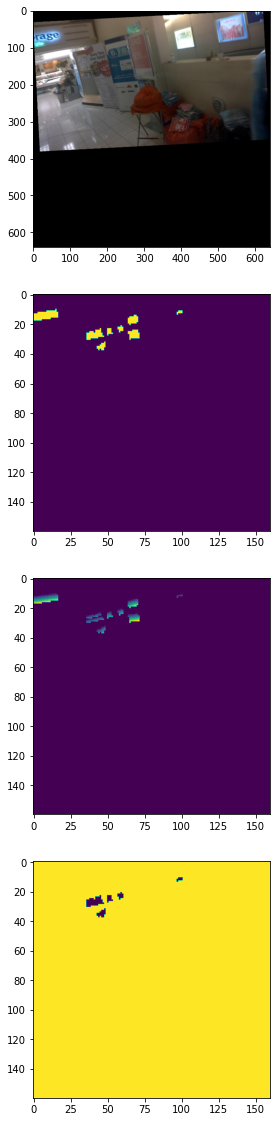

In [ ]:
######################################################################################################
### check cell                                                                                      ##
### Generator class
### 
###
######################################################################################################

#input_images_dir="Synth_sample/"
#input_gt_dir=""
#dataset="synth"
input_images_dir="icdar_comp/images/"
input_gt_dir="icdar_comp/ground_truth/"
dataset="icdar"

'''batch_images,batch_image_fns,batch_score_maps,batch_geo_maps,batch_training_masks,batch_transform_matrixes,batch_boxes_masks, \
batch_box_widths,batch_text_labels_sparse,batch_text_polyses, \
batch_text_labels=gen.generator(input_images_dir,input_gt_dir,dataset,limit=1000,input_size=512,batch_size=2)'''
aug_and_gen=Augment_and_generate()
gen=generator_class()
data=gen.generator(input_images_dir,input_gt_dir,dataset,limit=1000,input_size=640,batch_size=1)
for i in data:
    input_data,output=i
    
    print(len(input_data))
    batch_images,batch_text_polyses,batch_text_labels,batch_boxes_masks,transform_matrixes, box_widths,batch_rboxes=input_data
    batch_image_fns,batch_score_maps,batch_geo_maps,batch_training_masks,batch_text_labels_sparse,box_widths = output
    print("batch_rboxes:",batch_rboxes[0])
    plt.figure(figsize=(20, 20))
    plt.subplot(4, 1, 1) 
    print("Shape of batch_images[0]:",batch_images[0].shape)
    plt.imshow(batch_images[0])
    plt.subplot(4, 1, 2) 
    print("Shape of batch_score_maps[0]:",batch_score_maps[0].shape)
    plt.imshow(batch_score_maps[0][:,:,0]*128)
    plt.subplot(4, 1, 3) 
    print("Shape of batch_geo_maps[0]:",batch_geo_maps[0].shape)
    plt.imshow(batch_geo_maps[0][:,:,0] * 125)
    plt.subplot(4, 1, 4) 
    print("Shape of batch_training_masks[0]:",batch_training_masks[0].shape)
    plt.imshow(batch_training_masks[0][:,:,0] * 125)
    #plt.imshow(batch_images[0])
    #batch_image_fns,batch_score_maps,batch_geo_maps, \
    #    batch_boxes_masks,batch_text_labels_sparse = output
    break

**Multiprocess application.**

In [9]:
# class taken from FOTS-OCR github.



class GeneratorEnqueuer():
    """Builds a queue out of a data generator.
    Used in `fit_generator`, `evaluate_generator`, `predict_generator`.
    # Arguments
        generator: a generator function which endlessly yields data
        use_multiprocessing: use multiprocessing if True, otherwise threading
        wait_time: time to sleep in-between calls to `put()`
        random_seed: Initial seed for workers,
            will be incremented by one for each workers.
    """

    def __init__(self, generator,
                 use_multiprocessing=False,
                 wait_time=0.05,
                 random_seed=None):
        self.wait_time = wait_time
        self._generator = generator
        self._use_multiprocessing = use_multiprocessing
        self._threads = []
        self._stop_event = None
        self.queue = None
        self.random_seed = random_seed

    def start(self, workers=1, max_queue_size=10):
        """Kicks off threads which add data from the generator into the queue.
        # Arguments
            workers: number of worker threads
            max_queue_size: queue size
                (when full, threads could block on `put()`)
        """

        def data_generator_task():
            while not self._stop_event.is_set():
                try:
                    if self._use_multiprocessing or self.queue.qsize() < max_queue_size:
                        generator_output = next(self._generator)
                        self.queue.put(generator_output)
                    else:
                        time.sleep(self.wait_time)
                except Exception:
                    self._stop_event.set()
                    raise

        try:
            if self._use_multiprocessing:
                self.queue = multiprocessing.Queue(maxsize=max_queue_size)
                self._stop_event = multiprocessing.Event()
            else:
                self.queue = queue.Queue()
                self._stop_event = threading.Event()

            for _ in range(workers):
                if self._use_multiprocessing:
                    # Reset random seed else all children processes
                    # share the same seed
                    np.random.seed(self.random_seed)
                    thread = multiprocessing.Process(target=data_generator_task)
                    thread.daemon = True
                    if self.random_seed is not None:
                        self.random_seed += 1
                else:
                    thread = threading.Thread(target=data_generator_task)
                self._threads.append(thread)
                thread.start()
        except:
            self.stop()
            raise

    def is_running(self):
        return self._stop_event is not None and not self._stop_event.is_set()

    def stop(self, timeout=None):
        """Stops running threads and wait for them to exit, if necessary.
        Should be called by the same thread which called `start()`.
        # Arguments
            timeout: maximum time to wait on `thread.join()`.
        """
        if self.is_running():
            self._stop_event.set()

        for thread in self._threads:
            if thread.is_alive():
                if self._use_multiprocessing:
                    thread.terminate()
                else:
                    thread.join(timeout)

        if self._use_multiprocessing:
            if self.queue is not None:
                self.queue.close()

        self._threads = []
        self._stop_event = None
        self.queue = None

    def get(self):
        """Creates a generator to extract data from the queue.
        Skip the data if it is `None`.
        # Returns
            A generator
        """
        while self.is_running():
            if not self.queue.empty():
                inputs = self.queue.get()
                if inputs is not None:
                    yield inputs
            else:
                time.sleep(self.wait_time)

**multiprocess-working:**

* start : access generator and start puting inputs in queue
* get : get(yield) the inputs from the queue,till queu becomes empty
* stop : stop the queue when theres a error,since our generator is an infinite loop,it wont stop unless stopped manually or errored.

So basically we are just putting inputs in queue to save a few milliseconds.


In [10]:
aug_and_gen=Augment_and_generate()
gen=generator_class()
def get_batch(num_workers,input_images_dir,input_gt_dir,dataset,limit,input_size,batch_size):
    try:
        #data=gen.generator(input_images_dir,input_gt_dir,dataset,limit=1000,input_size=512,batch_size=1)
        enqueuer = GeneratorEnqueuer(gen.generator(input_images_dir,input_gt_dir,dataset,limit,input_size,batch_size), use_multiprocessing=True)
        print('Generator use 5 batches for buffering, this may take a while, '
              'you can tune this yourself.')
        enqueuer.start(max_queue_size=5, workers=num_workers)
        generator_output = None
        while True:
            while enqueuer.is_running():
                if not enqueuer.queue.empty():
                    generator_output = enqueuer.queue.get()
                    break
                else:
                    time.sleep(0.01)
            yield generator_output
            generator_output = None
    finally:
        if enqueuer is not None:
            enqueuer.stop()

iter:  0
Generator use 5 batches for buffering, this may take a while, you can tune this yourself.
length of images: 12940
dataset_limit: 10000
images_list length: 10000
before loooop
length of images: 12940
dataset_limit: 10000
images_list length: 10000
length of images: 12940
before loooop
dataset_limit: 10000
images_list length: 10000
before loooop


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:377: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


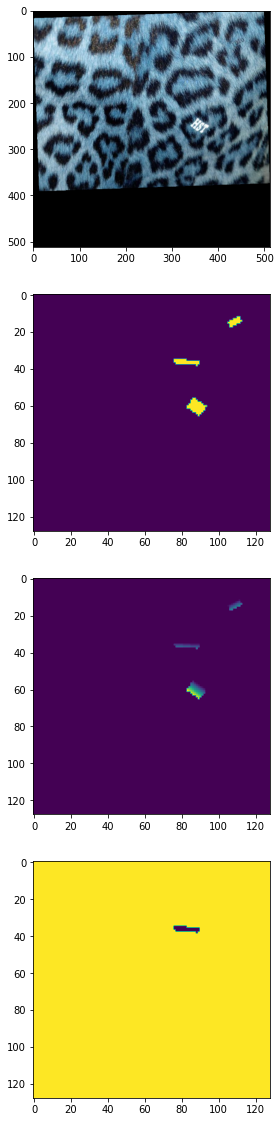

In [ ]:
######################################################################################################
### check cell                                                                                      ##
### Generator class with multiprocess
### 
###
######################################################################################################

input_images_dir="Synth_sample/"
input_gt_dir=""
dataset="synth"
#input_images_dir="icdar_comp/images/"
#input_gt_dir="icdar_comp/ground_truth/"
#dataset="icdar"

'''batch_images,batch_image_fns,batch_score_maps,batch_geo_maps,batch_training_masks,batch_transform_matrixes,batch_boxes_masks, \
batch_box_widths,batch_text_labels_sparse,batch_text_polyses, \
batch_text_labels=gen.generator(input_images_dir,input_gt_dir,dataset,limit=1000,input_size=512,batch_size=2)'''
aug_and_gen=Augment_and_generate()
gen=generator_class()

dg = get_batch(3,input_images_dir,input_gt_dir,dataset,limit=10000,input_size=512,batch_size=1)
for iter in range(2000):
        print("iter: ", iter)
       
        input_data,output = next(dg)
        batch_images,batch_text_polyses,batch_text_labels,batch_boxes_masks,transform_matrixes, box_widths,batch_rboxes=input_data
        batch_image_fns,batch_score_maps,batch_geo_maps,batch_training_masks,batch_text_labels_sparse,box_widths = output
        plt.figure(figsize=(20, 20))
        plt.subplot(4, 1, 1) 
        plt.imshow(batch_images[0])
        plt.subplot(4, 1, 2) 
        plt.imshow(batch_score_maps[0][:, :, 0]*128)
        plt.subplot(4, 1, 3) 
        plt.imshow(batch_geo_maps[0][:, :, 0] * 125)
        plt.subplot(4, 1, 4) 
        plt.imshow(batch_training_masks[0][:, :, 0] * 125)
        break

          

## **Model Building**

In [11]:
!pip install tensorflow-addons[tensorflow]

     |████████████████████████████████| 706kB 18.9MB/s 


In [12]:


#from tensorflow.python import keras

from tensorflow.python import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D,Bidirectional,LSTM
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
from tensorflow.keras import applications


import tensorflow_addons as tfa
tfa_enabled = True

try:
    import tensorflow_addons as tfa
    tfa_enabled = True
except ModuleNotFoundError:
    tfa_enabled = False
    print('tfa module not available. Will be using cv2 to rotate matrices \n'
          'Error will not be back-propagated from recognition branch \n'
          'to backbone branch. This mode is proper for inference only')

tf.config.run_functions_eagerly(True)

tf.executing_eagerly()

import logging
logging.getLogger('tensorflow').disabled = True



In [13]:
print(keras.__version__)

2.4.0


**Detect Model**

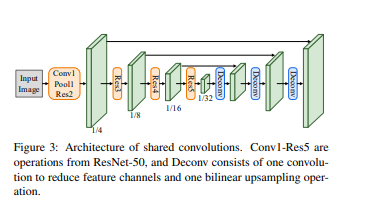

In [14]:
class Backbone(tf.keras.Model):

    

    def __init__(self,backbone='resnet', input_shape= (640,640,3), training=True):
        super(Backbone, self).__init__()

        self.training = training
        
        self.ip_shape=input_shape
        print("input:",self.ip_shape)
        if backbone == 'mobilenet':
            self.baskbone = tf.keras.applications.MobileNetV2(include_top=False, input_shape=input_shape)
            self.layer_ids = [153, 118, 56, 29]
        else:
            self.baskbone = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)
            self.layer_ids = [174, 142, 80, 12]
        #self.baskbone = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)
        #self.layer_ids = [174, 142, 80, 12]
        #self.baskbone = tf.keras.applications.MobileNetV2(input_shape= self.ip_shape,include_top=False)
        #self.layer_ids = [153, 118, 56, 29]
        
        self.backbone_name = backbone
        self.baskbone.trainable = False
        self.backbone_layers = tf.keras.models.Model(
            inputs=self.baskbone.input,
            outputs=[self.baskbone.get_layer(index=i).output for i in self.layer_ids])

        self.l1 = tf.keras.layers.Conv2D(filters=128, kernel_size=1, padding='same',name="cov2d_1")
        self.l2 = tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding='same',name="cov2d_2")
        self.l3 = tf.keras.layers.Conv2D(filters=32, kernel_size=1, padding='same',name="cov2d_3")

        self.h1 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same',name="cov2d_h1")
        self.h2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same',name="cov2d_h2")
        self.h3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same',name="cov2d_h3")

        # https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization
        # Scale: if True, multiply by gamma. If False, gamma is not used.
        # When the next layer is linear (also e.g. nn.relu),
        # this can be disabled since the scaling will be done by the next layer.
        self.bn1 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001,name="bn_1")
        self.bn2 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001,name="bn_2")
        self.bn3 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001,name="bn_3")

        self.g1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation=tf.nn.relu)

    def __call__(self, input):

        # layers extracted from Backbone model (ResNet or MobileNet):
        # 1st is the farthest one (near the end of the net),
        # 4th is the closest one (near the beggining)

        # preprocess input
       
        
        if 'mobile' in self.backbone_name.lower():
            input = tf.keras.applications.mobilenet.preprocess_input(input)
        else:
            input = tf.keras.applications.resnet50.preprocess_input(input)

        layer_1, layer_2, layer_3, layer_4 = self.backbone_layers(input)

        # step 1
        # layer_1 -> layer_1
        layer_shape = tf.shape(layer_1)
        layer_1 = tf.keras.layers.UpSampling2D(size=[2, 2])(layer_1)

        # step 2
        # layer_1 + layer_2 -> layer_12
        layer_12_conc = self.l1(tf.concat([layer_1, layer_2], axis=-1))
        layer_12_conv = self.h1(layer_12_conc)
        layer_12_conv = self.bn1(layer_12_conv)
        layer_12_conv = tf.nn.relu(layer_12_conv)
        layer_12 = tf.keras.layers.UpSampling2D(size=[2, 2])(layer_12_conv)

        # step 3
        # layer_12 + layer_3 -> layer_123
        layer_123_conc = self.l2(tf.concat([layer_12, layer_3], axis=-1))
        layer_123_conv = self.h2(layer_123_conc)
        layer_123_conv = self.bn2(layer_123_conv)
        layer_123_conv = tf.nn.relu(layer_123_conv)
        layer_123 = tf.keras.layers.UpSampling2D(size=[2, 2])(layer_123_conv)

        # step 4
        # layer_123 + layer_4 -> layer_1234
        layer_1234_conc = self.l3(tf.concat([layer_123, layer_4], axis=-1))
        layer_1234_conv = self.h3(layer_1234_conc)
        layer_1234_conv = self.bn3(layer_1234_conv)
        layer_1234_conv = tf.nn.relu(layer_1234_conv)

        layer_1234 = self.g1(layer_1234_conv)

        return layer_1234


In [15]:
class Detection(tf.keras.Model):

    

    def __init__(self):
        super(Detection, self).__init__()

        self.f_score = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation=tf.nn.sigmoid)
        self.geo_map = tf.keras.layers.Conv2D(filters=4, kernel_size=(1, 1), padding='same', activation=tf.nn.sigmoid)
        self.angle_map = tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1), padding='same', activation=tf.nn.sigmoid)

    def __call__(self, input):

        f_score = self.f_score(input)
        geo_map = self.geo_map(input) * 512
        angle_map = (self.angle_map(input) - 0.5) * np.pi / 2
        f_geometry = tf.concat([geo_map, angle_map], axis=-1)

        return f_score, f_geometry

    


**Backbone and Detection combined.**

In [ ]:
'''class Shared_conv(tf.keras.Model):
    
    def __init__(self, filters=[256,128,64], name="Shared_conv",input_shape=(640, 640, 3),training=True):
        super(Shared_conv,self).__init__(name="Shared_conv")
        self.F1, self.F2, self.F3 = filters
        self.res50=applications.ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=input_shape, \
                pooling=None, classes=1000)
        self.res50.trainable=training

        self.layer_ids = [174, 142, 80, 12]
        self.backbone_layers = tf.keras.models.Model(
            inputs=self.res50.input,
            outputs=[self.res50.get_layer(index=i).output for i in self.layer_ids])

        self.conv1=Conv2D(self.F1,kernel_size=(1,1),padding='same')
        self.conv2=Conv2D(self.F2,kernel_size=(1,1),padding='same')
        self.conv3=Conv2D(self.F3,kernel_size=(1,1),padding='same')
        
        self.upsamp1=UpSampling2D(size=(2,2),interpolation='bilinear')
        self.upsamp2=UpSampling2D(size=(2,2),interpolation='bilinear')
        self.upsamp3=UpSampling2D(size=(2,2),interpolation='bilinear')

        self.h1 = Conv2D(filters=self.F1, kernel_size=3, padding='same')
        self.h2 = Conv2D(filters=self.F2, kernel_size=3, padding='same')
        self.h3 = Conv2D(filters=self.F3, kernel_size=3, padding='same')

        self.bn1 = BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001)
        self.bn2 = BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001)
        self.bn3 = BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001)

        self.relu1=Activation('relu')
        self.relu2=Activation('relu')
        self.relu3=Activation('relu')
        self.relu4=Activation('relu')

        self.final_backbone = Conv2D(filters=32, kernel_size=3, padding='same')

        self.score_mask=Conv2D(1,kernel_size=(1,1),padding='same',activation='sigmoid')
        self.geo_maps=Conv2D(4,kernel_size=(1,1),padding='same',activation='sigmoid')
        self.angles=Conv2D(1,kernel_size=(1,1),padding='same',activation='sigmoid')

        
        
        
    def call(self, X):
        
        #shared convolution
        #print("input image:",X.shape)
        last,last_b1,last_b2,last_b3=self.backbone_layers(X)
        #print("res50 shape:",last.shape)
        deconv_1=self.upsamp1(last)
        #print("upsamp_1 shape:",deconv_1.shape)

        # deconv_1 + last_b1 -> concat_d1_l1
        concat_d1_l1 = self.conv1(tf.concat([deconv_1, last_b1], axis=-1))  
        layer_11_conv = self.h1(concat_d1_l1)   
        layer_11_conv = self.bn1(layer_11_conv) 
        layer_11_conv = self.relu1(layer_11_conv)
        deconv_2 = self.upsamp2(layer_11_conv)  
        #print("upsamp_2 shape:",deconv_2.shape)
        # deconv_2 + last_b2 -> concat_d2_l2
        concat_d2_l2 = self.conv2(tf.concat([deconv_2, last_b2], axis=-1))  
        layer_22_conv = self.h2(concat_d2_l2)   
        layer_22_conv = self.bn2(layer_22_conv) 
        layer_22_conv = self.relu2(layer_22_conv)
        deconv_3 = self.upsamp2(layer_22_conv)
        #print("upsamp_3 shape:",deconv_3.shape)
        # deconv_3 + last_b3 -> concat_d3_l3
        concat_d3_l3 = self.conv3(tf.concat([deconv_3, last_b3], axis=-1))  
        layer_33_conv = self.h3(concat_d3_l3)   
        layer_33_conv = self.bn3(layer_33_conv) 
        layer_33_conv = self.relu3(layer_33_conv)
        deconv_4 = self.upsamp3(layer_33_conv)
        #print("upsamp_4 shape:",deconv_4.shape)
        #final layer for backbone
        final=self.final_backbone(deconv_4)
        backbone = self.relu4(final)
        #print("backbone shape:",backbone.shape)
        
        #backbone done.
        #detect
        
        detect_mask=self.score_mask(backbone) # has probabilities
        #print("detect mask raw shape:",detect_mask.shape)
        #detect_mask=tf.reshape(detect_mask,(detect_mask.shape[0],512,512,detect_mask.shape[-1]))
        #print("detect_mask_shape:",detect_mask.shape)
        #print("##"*100)
        
        detect_geo=self.geo_maps(backbone)* 512  # to equalise it with 512,512 matrix
        #print("detect_geo_shape:",detect_geo.shape)
        
        detect_angle=(self.angles(backbone) - 0.5) * np.pi/2 # angle is between [-45, 45]
        #print("detect_angle_shape:",detect_angle.shape)
        
        F_geometry = tf.concat([detect_geo, detect_angle], axis=-1)
        #print("F_geometry shape:",F_geometry.shape)
        output=[backbone,detect_mask,F_geometry]  # backbone-> ROI and detec and F-geometry for bounding box
        
        return output'''

**Recognition model:**

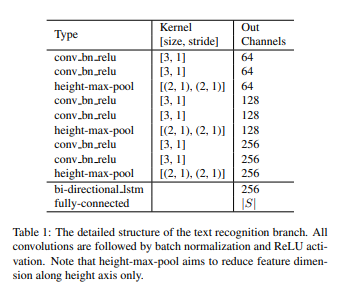

In [16]:
class Recognition(tf.keras.Model):

    

    def __init__(self, training=True, drop_prob=0.0):
        super(Recognition, self).__init__()
        self.drop_prob = drop_prob

        self.CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ#()+-"
        self.NUM_CLASSES = len(self.CHAR_VECTOR) + 1

        # cnn
        # 1st block
        self.layer_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same')
        self.bn_1 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001)
        self.pool_1 = tf.keras.layers.MaxPool2D(pool_size=[2, 1], strides=[2, 1], padding='same')

        # 2nd block
        self.layer_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same')
        self.bn_2 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001)
        self.pool_2 = tf.keras.layers.MaxPool2D(pool_size=[2, 1], strides=[2, 1], padding='same')

        # 3rd block
        self.layer_3 = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.bn_3 = tf.keras.layers.BatchNormalization(trainable=training, momentum=0.997, epsilon=0.00001)
        self.pool_3 = tf.keras.layers.MaxPool2D(pool_size=[2, 1], strides=[2, 1], padding='same')

        # # rnn
        lstm_fw_cell_1 = tf.keras.layers.LSTM(128, return_sequences=True, unit_forget_bias=True, dropout=self.drop_prob)
        lstm_bw_cell_1 = tf.keras.layers.LSTM(128, go_backwards=True, return_sequences=True, unit_forget_bias=True, dropout=self.drop_prob)
        self.bilstm_1 = tf.keras.layers.Bidirectional(layer=lstm_fw_cell_1, backward_layer=lstm_bw_cell_1)

        lstm_fw_cell_2 = tf.keras.layers.LSTM(128, return_sequences=True, unit_forget_bias=True, dropout=self.drop_prob)
        lstm_bw_cell_2 = tf.keras.layers.LSTM(128, go_backwards=True, unit_forget_bias=True, return_sequences=True, dropout=self.drop_prob)
        self.bilstm_2 = tf.keras.layers.Bidirectional(layer=lstm_fw_cell_2, backward_layer=lstm_bw_cell_2)

        # From the paper: To avoid overfitting on small training datasets
        # like ICDAR 2015, we add dropout before fully-connection.
        # https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Dropout
        self.dense = tf.keras.layers.Dense(self.NUM_CLASSES)  # number of classes + 1 blank char

    def __call__(self, input):

        # 1st block
        x = self.layer_1(input)
        x = self.bn_1(x)
        x = tf.nn.relu(x)  # activation after bn
        x = self.pool_1(x)

        # 2nd block
        x = self.layer_2(x)
        x = self.bn_2(x)
        x = tf.nn.relu(x)
        x = self.pool_2(x)

        # 3nd block
        x = self.layer_3(x)
        x = self.bn_3(x)
        x = tf.nn.relu(x)
        x = self.pool_3(x)

        # rnn
        x = tf.squeeze(x, axis=[1])  # [BATCH, TIME, FILTERS] because height of tensor is now 1
        x = self.bilstm_1(x)
        x = self.bilstm_2(x)
        # print([i.sum() for i in x.numpy()])

        logits = self.dense(x)

        return logits

    

**Another approach for recog:**

In [ ]:
'''class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=64,stride=1, name="identity_block"):
        
        super(identity_block,self).__init__(name=name)
        self.F1 = filters
        self.kernel = kernel
        self.stride=stride
        self.conv_1=Conv2D(self.F1,kernel_size=(3,3),strides=(self.stride, self.stride),padding='SAME')
        self.BN_1=BatchNormalization()
        self.activation_1=Activation('relu')
    
    def call(self, X):
        # write the architecutre that was mentioned above
        #print("identity input shape:",X.shape)
        conv1=self.conv_1(X)
        bn_1=self.BN_1(conv1)
        output=self.activation_1(bn_1)
        #print("identity output shape:",output.shape)
        return output'''

In [ ]:
'''class recognition(tf.keras.Model):
    
    def __init__(self, filters=[64,128,256], name="Recog_conv",drop_prob=0.0,training=True):
        super(recognition,self).__init__()
        self.F1, self.F2, self.F3 = filters
        self.drop_prob=drop_prob
        self.CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ-~`<>'.:;^/|!?$%#@&*()[]{}_+=,\\\""
        
        self.NUM_CLASSES = len(self.CHAR_VECTOR) + 1
        #layer 1
        self.id1=identity_block(filters=self.F1)
        self.id2=identity_block(filters=self.F1)
        self.max_pool1=MaxPooling2D(pool_size=(2, 1), strides=(2,1))
        #layer 2
        self.id3=identity_block(filters=self.F2)
        self.id4=identity_block(filters=self.F2)
        self.max_pool2=MaxPooling2D(pool_size=(2, 1), strides=(2,1))
        #layer 3
        self.id5=identity_block(filters=self.F3)
        self.id6=identity_block(filters=self.F3)
        self.max_pool3=MaxPooling2D(pool_size=(2, 1), strides=(2,1))
        
        
        
        self.dense_layer=Dense(self.NUM_CLASSES)
      #RNN 
        self.lstm_fw_1 = LSTM(128, return_sequences=True, unit_forget_bias=True, dropout=self.drop_prob)
        self.lstm_bw_1 = LSTM(128, go_backwards=True, return_sequences=True, unit_forget_bias=True, dropout=self.drop_prob)
        self.bi_lstm1=Bidirectional(layer=self.lstm_fw_1, backward_layer=self.lstm_bw_1)

        self.lstm_fw_2 = LSTM(128, return_sequences=True, unit_forget_bias=True, dropout=self.drop_prob)
        self.lstm_bw_2 = LSTM(128, go_backwards=True, return_sequences=True, unit_forget_bias=True, dropout=self.drop_prob)
        self.bi_lstm2=Bidirectional(layer=self.lstm_fw_2, backward_layer=self.lstm_bw_2) 

            
    def call(self, X):
        
        #num_rois = tf.shape(X)[0]
        #print("Recognise input:",X.shape)

        #layer 1
        conv_bn_relu1=self.id1(X)
        conv_bn_relu2=self.id2(conv_bn_relu1)
        height_max_pool1=self.max_pool1(conv_bn_relu2)
        #print("height_max_pool1 input:",height_max_pool1.shape)
        
        #layer2
        conv_bn_relu3=self.id3(height_max_pool1)
        conv_bn_relu4=self.id4(conv_bn_relu3)
        height_max_pool2=self.max_pool2(conv_bn_relu4)

        #layer 3
        conv_bn_relu5=self.id5(height_max_pool2)
        conv_bn_relu6=self.id6(conv_bn_relu5)
        height_max_pool3=self.max_pool3(conv_bn_relu6)
        #print("height_max_pool3:",height_max_pool3.shape) # N * 1 * W * C
        
        #RNN
        height_max_pool3 = tf.squeeze(height_max_pool3, axis=1) # N * W * C -> [BATCH, TIME, FILTERS] because height of tensor is now 1
        bi_direction_lstm1=self.bi_lstm1(height_max_pool3)
        #print("bi_direect shape:",bi_direction_lstm_output.shape)
        bi_direction_lstm12=self.bi_lstm2(bi_direction_lstm1)
        logits=self.dense_layer(bi_direction_lstm12)
        #print("logits shape:",logits.shape)
 
        #logits = tf.reshape(logits, [num_rois, -1, self.NUM_CLASSES])
        #logits = tf.transpose(logits, (1, 0, 2))
        #logits=tf.math.argmax(logits, axis=-1)
        #print("logits end shape:",logits.shape)
        
        return logits'''

**ROI Class**

In [47]:



class ROI_rotate(object):

    """
    The basic idea begind this branch is to output croped text regions from sharedconvs
    these cropped regions (boxes) will serve as an input into recongition branch
    For example:
    input   [1, 120, 160, 32] sharedconvs
    output  [7, 8, 64, 32] where [boxes, height, width, channels]
    https://github.com/yu20103983/FOTS/blob/master/FOTS/dataset/dataReader.py
    https://stackoverflow.com/questions/55160136/tensorflow-2-0-and-image-processing
    https://github.com/tensorflow/addons
    https://stackoverflow.com/questions/37042748/how-to-create-a-rotation-matrix-in-tensorflow
    """

    # reshape original image to shape of sharedconvs and roi rotate it to see what are the features
    #Quick_plot is not working,similar implementation is there is final test class.
   

    def __init__(self, features_stride=4, tfa_enabled=True):
        # self.features = features
        self.tfa_enabled = tfa_enabled
        self.features_stride = features_stride
        self.max_RoiWidth = int(256 / features_stride)
        self.fix_RoiHeight = int(32 / features_stride)
        self.ratio = float(self.fix_RoiHeight) / self.max_RoiWidth

    def quick_plot(self,x):

      #x=tf.constant(x)
      #proto_tensor = tf.make_tensor_proto(x)  # convert `tensor a` to a proto tensor
      #x=tf.make_ndarray(x)
      #x=tf.Session().run(x)
      # with tf.Session() as sess:

      # display encoded back to image data
      #  jpeg_bin = sess.run(x)
      #x=x.numpy()
      #cv2.imshow('org', x.astype(np.uint8))
      #print("type of x:",type(x))
      #print(x)
      plt.figure(figsize=(20, 20))
      plt.imshow(x)


    # decorating this with tf.function() throws an error: OSError: could not get source code
    # not sure why this went wrong as I've been using it with decoration previously
    # works fine on linux (because of tfa_enabled), does not work on windows
    @tf.function()
    def scanFunc(self, b_input, plot=False, expand_px=0):

        ifeatures, outBox, cropBox, angle = b_input
        # make sure box size is within image
        _, height, width, _ = ifeatures.shape
        offset_height = tf.clip_by_value(outBox[1]-expand_px, 1, height)
        offset_width = tf.clip_by_value(outBox[0]-expand_px, 1, width)
        target_height = tf.clip_by_value(outBox[3]+expand_px, 1, height - outBox[1]-expand_px)
        target_width = tf.clip_by_value(outBox[2]+expand_px, 1, width - outBox[0]-expand_px)

        cropFeatures = tf.image.crop_to_bounding_box(ifeatures, offset_height, offset_width, target_height, target_width)
        if plot:
            print("cropfeatures")
            for i in cropFeatures:
                print("i's")
                self.quick_plot(i.numpy())

        if self.tfa_enabled:
            textImgFeatures = tfa.image.rotate(cropFeatures, angles=angle)
        else:
            _, h, w, c = cropFeatures.shape
            print("w,h,expand_px:{0},{1},{2}".format(type(w),type(h),type(expand_px)))
            center = (int(w) / 2 + expand_px, int(h) / 2 + expand_px)
            width = cropBox[2] + expand_px * 4
            height = cropBox[3] + expand_px * 4
            matrix = cv2.getRotationMatrix2D(center=center, angle=math.degrees(math.atan(angle)), scale=1)  # https://stackoverflow.com/questions/10057854/inverse-of-tan-in-python-tan-1
            image = cv2.warpAffine(src=cropFeatures.numpy()[0, :, :, :], M=matrix, dsize=(w, h))
            x = int(center[0] - width / 2)
            y = int(center[1] - height / 2)
            textImgFeatures = image[y:y + height, x:x + width, :][np.newaxis, :, :, :]

        #if plot:
        #    for i in [textImgFeatures.numpy() if self.tfa_enabled else textImgFeatures][0]:
        #        self.quick_plot(i.numpy())

        # ------------- #

        # resize keep ratio
        w = tf.cast(tf.math.ceil(tf.multiply(tf.divide(self.fix_RoiHeight, cropBox[3]+expand_px*4), tf.cast(cropBox[2]+expand_px*4, tf.float64))), tf.int32)
        resize_textImgFeatures = tf.image.resize(textImgFeatures, (self.fix_RoiHeight, w))
        #if plot:
        #    for i in resize_textImgFeatures:
         #       quick_plot(i.numpy())
        w = tf.minimum(w, self.max_RoiWidth)

        # crop rotated corners
        pad_or_crop_textImgFeatures = tf.image.crop_to_bounding_box(resize_textImgFeatures, 0, 0, self.fix_RoiHeight, w)
        pad_or_crop_textImgFeatures = tf.image.pad_to_bounding_box(pad_or_crop_textImgFeatures, 0, 0, self.fix_RoiHeight, self.max_RoiWidth)
        if plot:
            for i in pad_or_crop_textImgFeatures:
                self.quick_plot(i.numpy())

        return [pad_or_crop_textImgFeatures, w]

     
       

    def __call__(self, features, brboxes, expand_w=20, plot=False, expand_px=0):

        # features = x_batch['images']
        # brboxes = x_batch['rboxes']

        
        paddings = tf.constant([[0, 0], [expand_w, expand_w], [expand_w, expand_w], [0, 0]])
        features_pad = tf.pad(features, paddings, "CONSTANT")
        features_pad = tf.expand_dims(features_pad, axis=1)  # [b, 1, h, w, c]

        btextImgFeatures = []
        ws = []
        #print("brboxes:",len(brboxes))
        # loop over images in batch
        for b, rboxes in enumerate(brboxes):

            outBoxes, cropBoxes, angles = rboxes
            outBoxes = tf.constant(outBoxes, dtype=tf.int32)
            cropBoxes = tf.constant(cropBoxes, dtype=tf.int32)
            angles = tf.constant(angles, dtype=tf.float32)

            # not sure if all is good, maybe +1 width and +1 height????
            outBoxes = tf.cast(tf.math.divide(outBoxes, self.features_stride), tf.int32)
            cropBoxes = tf.cast(tf.math.divide(cropBoxes, self.features_stride), tf.int32)

            outBoxes_xy = outBoxes[:, :2]
            outBoxes_xy = tf.add(outBoxes_xy, expand_w)
            outBoxes = tf.concat([outBoxes_xy, outBoxes[:, 2:]], axis=1)
            #print("b:",b)
            #print("rboxes:",rboxes)
            ifeatures_pad = features_pad[b]

            # for every box
            croped_ft = []
            croped_ft_w = []
            for outB, cropB, ang in zip(outBoxes, cropBoxes, angles):
                out = self.scanFunc(b_input=(ifeatures_pad, outB, cropB, ang), plot=plot, expand_px=expand_px)
                croped_ft.append(out[0])
                croped_ft_w.append(out[1])

            textImgFeatures = [tf.concat(croped_ft, axis=0), croped_ft_w]

            # the below code produces OOM because if there are many boxes,
            # tf, tile will produce a massive matrix hence for now the above solution
            # len_crop = tf.shape(outBoxes)[0]
            # ifeatures_tile = tf.tile(ifeatures_pad, [len_crop, 1, 1, 1])  # repeat matrix on 1 axis (for each box)
            # textImgFeatures = tf.scan(self.scanFunc, [ifeatures_tile, outBoxes, cropBoxes, angles],
            #                           [np.zeros((self.fix_RoiHeight, self.max_RoiWidth, channels), np.float32),
            #                            np.array(0, np.int32)])

            btextImgFeatures.append(textImgFeatures[0])
            ws.append(textImgFeatures[1])

        btextImgFeatures = tf.concat(btextImgFeatures, axis=0)
        ws = tf.concat(ws, axis=0)

        return btextImgFeatures, ws

In [87]:
shared=Backbone(backbone='mobilenet')
detect=Detection()
roi=ROI_rotate()
recognize_model=Recognition()

input: (640, 640, 3)


In [71]:
aug_and_gen=Augment_and_generate()
gen=generator_class()

**Definig Loss:**

In [20]:
class Model_loss():
     
    def dice_coefficient(self, y_true_cls, y_pred_cls, training_mask):
        
        '''
        dice loss
        :param y_true_cls:
        :param y_pred_cls:
        :param training_mask:
        :return:
        '''
        #y_pred_cls=tf.squeeze(y_pred_cls,axis=-1)
       
        eps = 1e-5
        intersection = tf.reduce_sum(y_true_cls * y_pred_cls * training_mask)
        
        union = tf.reduce_sum(y_true_cls * training_mask) + tf.reduce_sum(y_pred_cls * training_mask) 
        loss = 1. - (2 * intersection / union)
        tf.summary.scalar('classification_dice_loss', loss)
        #print("dice coefficient:",loss)
        return loss

    def loss_classification_crossentrophy(self,f_score, f_score_pred, training_mask):
        """
        cross enthropy
        :param f_score: ground truth of text
        :param f_score_: prediction os text
        :param training_mask: mask used in training, to ignore some text annotated by ###
                :return:
        """

        loss = tf.keras.losses.binary_crossentropy(f_score * training_mask,
                                                   f_score_pred * training_mask,
                                                   from_logits=False,
                                                   label_smoothing=0)
        return tf.reduce_mean(loss)
    
    def detect_loss(self, y_true_cls, y_pred_cls, y_true_geo, y_pred_geo, training_mask):
        '''
        define the loss used for training, contraning two part,
        the first part we use dice loss instead of weighted logloss,
        the second part is the iou loss defined in the paper
        '''
       
        #print("y_pred_cls:",y_pred_cls.shape)
        #print("y_true_cls:",y_true_cls.shape)
        #print("y_true_geo:",y_true_geo.shape)
        #print("y_pred_geo:",y_pred_geo.shape)
        #print("training_mask:",training_mask.shape)
        


        classification_loss = self.dice_coefficient(y_true_cls, y_pred_cls, training_mask)
        # scale classification loss to match the iou loss part
        classification_loss *= 0.01
        #print("detect loss -> y_pred_geo:",y_pred_geo.shape)
        #print("detect loss -> y_true_geo:",y_true_geo.shape)
        # d1 -> top, d2->right, d3->bottom, d4->left
        d1_gt, d2_gt, d3_gt, d4_gt, theta_gt = tf.split(value=y_true_geo,
                                                        num_or_size_splits=5,
                                                        axis=3)
        d1_pred, d2_pred, d3_pred, d4_pred, theta_pred = tf.split(value=y_pred_geo,
                                                                  num_or_size_splits=5,
                                                                  axis=3)
        area_gt = (d1_gt + d3_gt) * (d2_gt + d4_gt)
        area_pred = (d1_pred + d3_pred) * (d2_pred + d4_pred)
        w_union = tf.minimum(d2_gt, d2_pred) + tf.minimum(d4_gt, d4_pred)
        h_union = tf.minimum(d1_gt, d1_pred) + tf.minimum(d3_gt, d3_pred)
        area_intersect = w_union * h_union
        area_union = area_gt + area_pred - area_intersect
        L_AABB = -tf.math.log((area_intersect + 1.0)/(area_union + 1.0)) # shape=(batch,512,512,1)
        #L_AABB=tf.squeeze(L_AABB,axis=-1)
        #print("L_AABB:",L_AABB.shape)
        L_theta = 1 - tf.math.cos(theta_pred - theta_gt)
        #L_theta=tf.squeeze(L_theta,axis=-1)
        #print("L_theta:",L_theta.shape)
        loss_iou = tf.reduce_mean(L_AABB * y_true_cls * training_mask)
        loss_angle = tf.reduce_mean(L_theta * 20 * y_true_cls * training_mask)
        
        fscore_loss=self.loss_classification_crossentrophy(y_true_cls, y_pred_cls, training_mask)
        
        Loss = loss_iou + loss_angle + fscore_loss
        #print("detect_loss:",Loss)
        
        return Loss

    
    def recog_loss(self,targets,logits, seq_len):
        # Loss and cost calculation
        #targets is a sparse tensor
        #indices, values, dense_shape = targets
        #y_sparse = tf.sparse.SparseTensor(indices=indices, values=values, dense_shape=dense_shape)
        indices=tf.cast(targets.indices, tf.int32)
        label_length = tf.math.bincount(indices[:, 0])
        loss = tf.nn.ctc_loss(labels=targets,
                              logits=tf.transpose(logits, [1, 0, 2]),
                              label_length=label_length,
                              logit_length=[len(logits[-1]) for _ in logits],  # logits [batch, time, nclass]
                              blank_index=-1)  # -1 will reproduce the behavior of using num_classes-1 for the blank

        return tf.reduce_mean(loss)
    
    def total_loss(self,data_true,predicted,flag):
        #print("lossssss")
        #detect_mask,detect_geo,predicted_labels,batch_text_polyses,batch_text_labels,batch_boxes_masks,batch_box_widths=predicted
        
        '''input_data=[batch_images,batch_text_polyses,batch_text_labels,batch_training_masks]
                        output=[batch_image_fns,batch_score_maps,batch_geo_maps, \
                               batch_boxes_masks \
                                ,batch_text_labels_sparse]'''
        
        batch_image_fns,batch_score_maps,batch_geo_maps, \
        batch_training_masks,batch_text_labels_sparse,batch_box_widths = data_true
        
        
        lamda=1
        recog_loss=0
        if(flag==0): #train only detect model
            detect_mask,detect_geo=predicted
            detect_loss=self.detect_loss(batch_score_maps, detect_mask, batch_geo_maps, detect_geo, batch_training_masks)
            total_loss=lamda*detect_loss
            #print("total_loss:",total_loss)
        elif(flag==1): #train only recognition
            predicted_labels,seq_len=predicted
            recog_loss=self.recog_loss(batch_text_labels_sparse,predicted_labels,seq_len)
            total_loss=recog_loss
            #print("total_loss:",total_loss)
        elif(flag==2): #train both
            detect_mask,detect_geo,predicted_labels,seq_len=predicted
            recog_loss=self.recog_loss(batch_text_labels_sparse,predicted_labels,seq_len)
            detect_loss=self.detect_loss(batch_score_maps, detect_mask, batch_geo_maps, detect_geo, batch_training_masks)
            total_loss=[recog_loss,detect_loss]
            #print("total_loss:",total_loss)
            
        else:
            print("#"*50)
            print("INVALID FLAG")
            print("#"*50)
        return total_loss
    

**Initialising loss and optimizer**

In [21]:
modelloss=Model_loss()
loss_object=modelloss.total_loss
optimizer= tf.keras.optimizers.Adam()
#fots.compile(optimizer=optimizer,loss=loss_object)

**unzip previously Trained model weights:**

In [ ]:
!wget --header="Host: doc-0g-40-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.114 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_81hluv81adjprjfo5ucus7r4g5c0fm3t=13641879967109176128|1617897675000|pa3tgrghs5m312fqd2dprs98movb2jsi" --header="Connection: keep-alive" "https://doc-0g-40-docs.googleusercontent.com/docs/securesc/qsegjfskkrpjhbbv9npr5i2j9ukntgkv/gjrhh3fhqqb0thnqg25tff5jcvpdrnuo/1617897900000/13641879967109176128/13641879967109176128/1Z5KR-szxBatA8TQea8URPiUw-Omo0r7j?e=download&authuser=1" -c -O 'checkpoints.rar'

In [ ]:
!unrar x checkpoints.rar

**train  model:** 

In [64]:
####################################
#
#   params ->
#  flag=0 only train detect model
#  flag=1 train only recog model
#  model_load=0 fetch pretrained detect model
#  model_load=1 fetch pretrained detect and recog model
# model_load=2  no pretrained model,train fresh
#  flag=2 trian both models ** Not working ** (since there is no backpropagation between both models due to roi(non tf method))
#######################################


class Train_model():

  def __init__(self,dataset="synth",batch_size=4,epoch=3,limit=4000,num_workers=2,input_size=640,cpkt_dir="checkpoints/"):

    self.cpkt_dir=cpkt_dir
    self.input_size=input_size
    self.batch_size=batch_size
    self.epochs=epoch
    self.limit=limit

    self.shared=Backbone()
    self.detect=Detection()
    self.roi=ROI_rotate()
    self.recognize_model=Recognition()
    
    self.num_workers=num_workers
    if (dataset=="synth"):
      self.input_images_dir="Synth_sample/"
      self.input_gt_dir=""
      self.dataset="synth"
    elif (dataset=="icdar"):
      self.input_images_dir="icdar_2015/images/"
      self.input_gt_dir="icdar_2015/ground_truth/"
      self.dataset="icdar"

    self.CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ#()+-"

  def decode_to_text(self,char_dict, decoded_out):
    return ''.join([char_dict[i] for i in decoded_out])

  def train_step(self,input_data, output,flag):

    

    batch_images,batch_text_polyses,batch_text_labels,batch_box_masks,transform_matrixes,box_widths,batch_rbox=input_data
    batch_image_fns,batch_score_maps,batch_geo_maps,batch_training_masks,batch_text_labels_sparse,batch_box_widths = output
    
    #print("enter train_step")
    if (flag==0):

      #train only detect model
     # print("enter train_step")

      with tf.GradientTape() as tape:
        #print("enter gradient tape")
        shared_features = self.shared(batch_images)
        detect_predictions=self.detect(shared_features)
        detect_mask,detect_geo=detect_predictions
        #detect_predictions=[detect_mask,detect_geo]
        #print("detect predictions done... next step claculating loss")
        loss = loss_object(output, [detect_mask,detect_geo],flag)
      detect_gradients = tape.gradient(loss, self.shared.trainable_variables+self.detect.trainable_variables)
      optimizer.apply_gradients(zip(detect_gradients, self.shared.trainable_variables+self.detect.trainable_variables))
    elif (flag==1):
      #train only recognistion model
      with tf.GradientTape() as tape:
        #print("enter gradient tape")
        shared_features = self.shared(batch_images)
        detect_predictions=self.detect(shared_features)
        detect_mask,detect_geo=detect_predictions
        pad_rois,seq_len=self.roi(shared_features,batch_rbox)
        recog_labels = self.recognize_model(pad_rois)
            #print("recog predictions done... next step claculating loss")
        loss = loss_object(output, [recog_labels,seq_len],flag)
      recog_gradients = tape.gradient(loss, self.recognize_model.trainable_variables)
      optimizer.apply_gradients(zip(recog_gradients, self.recognize_model.trainable_variables))
    elif (flag==2): #train both models

            with tf.GradientTape() as tape:
                detect_predictions = shared_detect_model(batch_images, training=True)
                shared,detect_mask,detect_geo=detect_predictions
                pad_rois,seq_len=roi(shared,batch_rbox)
                recog_labels = recognize_model(pad_rois, training=True)
                #print("Detect and Recog predictions done... next step claculating loss")
                detect_loss,recog_loss = loss_object(output, [detect_mask,detect_geo,recog_labels,seq_len],flag)
            lamda=0.01
            loss=(lamda*detect_loss)+recog_loss
            gradients = tape.gradient(loss, shared_detect_model.trainable_variables+recognize_model.trainable_variables)
            print(gradients)
            optimizer.apply_gradients(zip(gradients, shared_detect_model.trainable_variables+recognize_model.trainable_variables))
    else:
        print("#"*50)
        print("INVALID Flag")
        print("#"*50)
        return False

    #y_true = tf.sparse.to_dense(batch_text_labels_sparse).numpy()
    #print("y_true:",y_true)
    #decoded, _ = tf.nn.ctc_greedy_decoder(recog_labels.numpy().transpose((1, 0, 2)), sequence_length=[recog_labels.shape[1]] * recog_labels.shape[0])
    #decoded = tf.sparse.to_dense(decoded[0]).numpy()
    #print("decoded:",decoded)
    #print([self.decode_to_text(self.CHAR_VECTOR, [j for j in i if j != 0]) for i in decoded[:4, :]],
     #     [self.decode_to_text(self.CHAR_VECTOR, [j for j in i if j != 0]) for i in y_true[:4, :]])
    #print(loss)
    return loss
  
  def __call__(self,flag,load_model=False): 
    
    loss_steps=[]
    loss_per_epoch=[]
    #data=gen.generator(input_images_dir,input_gt_dir,dataset,limit=limit,input_size=512,batch_size=batch_size) #without multiprocess
    dg = get_batch(self.num_workers,self.input_images_dir,self.input_gt_dir,self.dataset,limit=self.limit,input_size=self.input_size,batch_size=self.batch_size)
    invalid_flag=1
    min_loss=1000
    steps_per_epoch=int(self.limit/self.batch_size)

    if load_model and (flag==0):
        self.shared.load_weights(self.cpkt_dir + 'sharedconv')
        self.detect.load_weights(self.cpkt_dir + 'detection')
    elif load_model and (flag==1):
        self.recognize_model.load_weights(cpkt_dir + 'recognition')

    for epoch in range(self.epochs):

      count=0
      total_loss=0
      epochStart = time.time()
      for i in range(steps_per_epoch):
        count+=1
        input_data,output=next(dg)
        #print("train_step")
        loss=self.train_step(input_data, output,flag)
        #print(loss)
        if (loss):
          loss_steps.append(loss)
          total_loss+=loss
          epochEnd = time.time()
          elapsed = (epochEnd - epochStart) / 60.0
            #print("loss:",loss)
          print('epoch:{3}... progress:{0}/{1}...loss:{2}...time_spent:{4} mins\r'. \
                             format(count,int(steps_per_epoch),loss,(epoch+1),elapsed))
       # sys.stdout.flush()
        else:
          print("INVALID FLAG..Please check")
          invalid_flag=0
          break
        
      total_loss_mean=total_loss/(steps_per_epoch)
      loss_per_epoch.append(total_loss_mean)
      print("#"*50)
      print('epoch:{3}... progress:{0}/{1}...total_loss_mean:{2}...time_spent:{4} mins\r'. \
                             format(count,int(steps_per_epoch),total_loss_mean,(epoch+1),elapsed))
      print("#"*50)
      if (total_loss_mean < min_loss):  #checkpoint 
        if (flag==0):
          self.shared.save_weights("sharedconv")
          self.detect.save_weights("detection")
          print("model weights saved")
          min_loss=total_loss_mean
        elif (flag==1):
          self.recognize_model.save_weights( 'recognition')
          print("model weights saved")
          min_loss=total_loss_mean
   # sys.stdout.write("\n")
      if (invalid_flag==0):
          break
    return loss_steps,loss_per_epoch
    
#train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_loss(loss)
#train_accuracy(labels, predictions)

In [ ]:
tf.keras.backend.clear_session


<function tensorflow.python.keras.backend.clear_session>

**Training Detect Model:**

In [75]:
####################################
#
#   params ->
#  flag=0 only traon detect model
#  flag=1 train only recog model
#  model_load=0 fetch pretrained detect model
#  model_load=1 fetch pretrained detect and recog model
# model_load=2  no pretrained model,train fresh
#  flag=2 trian both models ** Not working ** (since there is no backpropagation between both models due to roi(non tf method))
#######################################
#(self,dataset="synth",batch_size=4,epoch=3,limit=4000,num_workers=2,input_size=640)
trainingmodel_detect=Train_model(limit=20,epoch=1)
loss_detectmodel,loss_per_epoch_detectmodel=trainingmodel_detect(flag=0)


input: (640, 640, 3)
Generator use 5 batches for buffering, this may take a while, you can tune this yourself.
length of images: 12940
dataset_limit: 20
images_list length: 20
length of images: 12940
dataset_limit: 20
images_list length: 20
epoch:1... progress:1/5...loss:0.7730962038040161...time_spent:0.1726296067237854 mins
epoch:1... progress:2/5...loss:0.6067591309547424...time_spent:0.18743230104446412 mins
epoch:1... progress:3/5...loss:0.4371280074119568...time_spent:0.3077340602874756 mins
epoch:1... progress:4/5...loss:0.41594797372817993...time_spent:0.3913543144861857 mins
epoch:1... progress:5/5...loss:0.3647271394729614...time_spent:0.5252377430597941 mins
##################################################
epoch:1... progress:5/5...total_loss_mean:0.5195317268371582...time_spent:0.5252377430597941 mins
##################################################
model weights saved


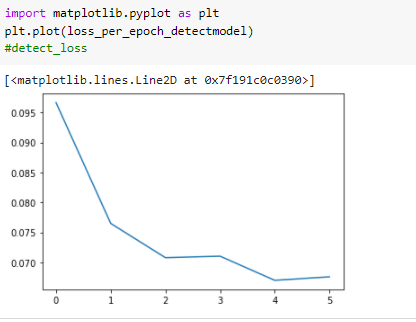

* Train detect model till 0.06 loss.

**Training Recog Model:**

In [76]:
trainingmodel_detect=Train_model(limit=20,epoch=1)
loss_detectmodel,loss_per_epoch_detectmodel=trainingmodel_detect(flag=1)

input: (640, 640, 3)
Generator use 5 batches for buffering, this may take a while, you can tune this yourself.
length of images: 12940
dataset_limit: 20
images_list length: 20
length of images: 12940
dataset_limit: 20
images_list length: 20
epoch:1... progress:1/5...loss:238.00010681152344...time_spent:0.19341447750727336 mins
epoch:1... progress:2/5...loss:168.7408905029297...time_spent:0.2096426208813985 mins
epoch:1... progress:3/5...loss:95.27379608154297...time_spent:0.26584271192550657 mins
epoch:1... progress:4/5...loss:37.183841705322266...time_spent:0.44411646127700805 mins
epoch:1... progress:5/5...loss:17.112504959106445...time_spent:0.4645590821901957 mins
##################################################
epoch:1... progress:5/5...total_loss_mean:111.2622299194336...time_spent:0.4645590821901957 mins
##################################################
model weights saved


* trained recog till 11.01 loss.

**Test**

In [ ]:
! apt install tesseract-ocr
! apt install libtesseract-dev

In [ ]:
!pip install pytesseract

In [27]:

import pytesseract
from PIL import Image




In [48]:

class test_model():

  def __init__(self,cpkt_dir='checkpoints/',load_models = True,input_shape = [640, 640, 3]):

    self.cpkt_dir = cpkt_dir
    self.load_models = load_models
    self.loss_hist = []
    self.input_shape = input_shape
    self.CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ#()+-"
    self.shared=Backbone(backbone='mobilenet',training=False)
    self.detect=Detection()
    self.model_RoI=ROI_rotate(tfa_enabled=True)
    self.recognize_model=Recognition(training=False)
#model_sharedconv = Backbone(backbone='mobilenet', input_shape=input_shape, training=False)
#model_detection = Detection()
#model_RoIrotate = RoIRotate(tfa_enabled=tfa_enabled)
#model_recognition = Recognition(num_classes=len(CHAR_VECTOR)+1, training=False, drop_prob=0)

  def restore_rectangle_rbox(self,origin, geometry):

    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])

  def decode_to_text(self,char_dict, decoded_out):
    return ''.join([char_dict[i] for i in decoded_out])

  def __call__(self,path,flag=1,video_flag=0,tes=0,plot=False):
    if self.load_models:
      self.shared.load_weights("checkpoints/sharedconv")
      self.detect.load_weights("checkpoints/detection")
      if (flag==1):
        self.recognize_model.load_weights("checkpoints/recognition")

# -------- #
    if (video_flag==1):
      vid = cv2.VideoCapture(path)
    while True:

        if (video_flag==1):
          _, im = vid.read()
        elif (video_flag==0):
          im = cv2.imread(path)
          im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
        # im = cv2.imread('D:/data/SynthText/SynthText/13/bay+area_2_19.jpg')

        im = cv2.resize(im, (640, 640))
        new_h, new_w, _ = im.shape
        max_h_w_i = np.max([new_h, new_w])
        im_padded = np.zeros((max_h_w_i, max_h_w_i, 3), dtype=np.uint8)
        im_padded[:new_h, :new_w, :] = im.copy()
        im = im_padded[np.newaxis, :, :, :].astype(np.float)

        # detection
        sharedconv = self.shared(im.copy())  # x_batch['images'].shape
        f_score_, geo_score_ = self.detect(sharedconv)

        # -------- #
        score_map_thresh = 0.20
        f_score = f_score_[0, :, :, 0].numpy()
        geo_score = geo_score_[0, :, :, ].numpy()

        # filter out by score map
        xy_text = np.argwhere(f_score > score_map_thresh)
        xy_text = xy_text[np.argsort(xy_text[:, 0])]

        if len(xy_text) > 0:

            # restore to coordinates
            text_box_restored = self.restore_rectangle_rbox(origin=xy_text[:, ::-1] * 4,
                                              geometry=geo_score[xy_text[:, 0], xy_text[:, 1], :])  # N*4*2

        # filter out by average score
        # box_thresh = 0.95
        # ids = []
        # for i, box in enumerate(text_box_restored):
        #     mask = np.zeros_like(f_score_[0, :, :, :], dtype=np.uint8)
        #     mask = cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32) // 4, 1)
        #     id = cv2.mean(f_score_[0, :, :, :].numpy(), mask)[0]
        #     ids.append(id)
        # text_box_restored = text_box_restored[np.array(ids) > box_thresh]

            # nms
            selected_indices = tf.image.non_max_suppression(boxes=text_box_restored[:, ::2, :].reshape((-1, 4)).astype(np.float32),
                                                        scores=f_score[xy_text[:, 0], xy_text[:, 1]],
                                                        max_output_size=50,
                                                        iou_threshold=0.01)

            #print(text_box_restored.shape[0], selected_indices.shape)

            if len(selected_indices) > 0 and (flag==1):

            # ----------- #
            # recognition

                rboxes = []
                box_coordinates, box_crops, angles = [], [], []
                for i in selected_indices:
                    bb = text_box_restored[i]

                    bb_corrds = int(bb[0, 0]), int(bb[0, 1]), int((bb[:, 0].max() - bb[:, 0].min())), int((bb[:, 1].max() - bb[:, 1].min()))
                    bb_corrds = list(bb_corrds)
                    bb_corrds_ = bb_corrds.copy()
                    bb_corrds_[0:2] = 0, 0
                    angle = geo_score[xy_text[i, :][1], xy_text[i, :][0]][-1]

                    box_coordinates.append(bb_corrds)
                    box_crops.append(bb_corrds_),
                    angles.append(angle)
                rboxes = [[box_coordinates, box_crops, angles]]

            # indices = xy_text[selected_indices, :]
            # indices[:, 0], indices[:, 1] = indices[:, 1].copy(), indices[:, 0].copy()
            # height = geo_score[indices[:, 0], indices[:, 1], :][:, 0:2].sum(axis=1)
            # width = geo_score[indices[:, 0], indices[:, 1], :][:, 2:4].sum(axis=1)
            # angle = geo_score[indices[:, 0], indices[:, 1], :][:, -1]
            #
            # text_coords = np.concatenate([indices, height.reshape(-1, 1), width.reshape(-1, 1)], axis=1).astype(np.int)
            # text_crop = text_coords.copy()
            # text_crop[:, 0:2] = 0
            # rboxes = [[text_coords.tolist(), text_crop.tolist(), angle.tolist()]]

                
                #print(features)
                
                features, ws = self.model_RoI(sharedconv, rboxes, expand_px=0, plot=plot)  # x_batch['rboxes']
                logits = self.recognize_model(features)

                decoded, log_prob = tf.nn.ctc_greedy_decoder(logits.numpy().transpose((1, 0, 2)),
                                                         sequence_length=[64] * logits.shape[0])
                decoded = tf.sparse.to_dense(decoded[0]).numpy()
                recognition = [self.decode_to_text(self.CHAR_VECTOR, [j for j in i if j != 0]) for i in decoded]
                #print(recognition)
                
            elif( tes == 1):
              recognition=[]
              for i, box in enumerate(text_box_restored[selected_indices, :, :]):
                
                box=box.astype(np.int32)
                
                if (tes==1):
                  x1=box[0][0]
                  y1=box[0][1]
                  x2=box[2][0]
                  y2=box[2][1]
                  #plt.figure(figsize=(2, 2))

                  roi = im_padded[y1:y2, x1:x2].copy()
                  
                  if(roi.size>3):
                    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
                    #plt.imshow(roi)
                    image = Image.fromarray(roi)
                    #config = ('-l eng --oem 1 --psm 3')
                    text = pytesseract.image_to_string(image, lang='eng', config="--oem 1 --psm 6")
                    #print(text)
                    recognition.append(text)
                  else:
                    recognition.append("###")

                  
                  

        # plot boxes
            if (tes==1) and (flag==0):
               for i, box in enumerate(text_box_restored[selected_indices, :, :]):

                 box=box.astype(np.int32)
                 im_padded = cv2.polylines(im_padded[:, :, :].copy(), [box], True, color=(255, 255, 0), thickness=1)

            # Draw recognition results area
                 if len(selected_indices) > 0:
                    text_area = box.copy()
                    
                    text_area[2, 1], text_area[3, 1], text_area[0, 1], text_area[1, 1] = text_area[1, 1], text_area[0, 1], text_area[0, 1] - 15, text_area[1, 1] - 15
                    im_padded = cv2.fillPoly(im_padded.copy(), [text_area.astype(np.int32).reshape((-1, 1, 2))], color=(255, 255, 0))
                    im_padded = cv2.putText(im_padded.copy(), recognition[i], (box.astype(np.int32)[0, 0], box.astype(np.int32)[0, 1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
        #print("Recognition Texts:",recognition)
        plt.figure(figsize=(20, 20))
        #plt.subplot(4, 1, 1)
        #plt.imshow(im_padded.astype(np.uint8))
        #plt.subplot(4, 1, 2) 
        detection = cv2.resize(f_score_.numpy().copy()[0, :, :, :], im_padded.shape[:2]) * 255
        #plt.imshow(detection.astype(np.uint8))
        detection = cv2.merge((detection, detection, detection)).astype(np.uint8) * 255
        #plt.subplot(4, 1, 3)
        #plt.imshow(detection.astype(np.uint8))
        im_padded = np.concatenate([im_padded, detection], axis=1)
        #plt.subplot(4, 1, 4)
        plt.imshow(im_padded.astype(np.uint8))
        # cv2.waitKey(0)

    # RoIrotate_test = RoIRotate(features_stride=1)
    # _, _ = RoIrotate_test(im, rboxes, expand_px=1, plot=True)  # x_batch['rboxes']

        if (video_flag==1):
          if cv2.waitKey(1) & 0xFF == ord('q'):
              vid.release()
              cv2.destroyAllWindows()
              return recognition
        else:
          return recognition

**Character wise accuracy:**

In [30]:
def Convert(string):
    list1=[]
    list1[:0]=string
    return list1

def character_acc(CHAR_VECTOR,recognition_pred,recognition_true):
  a=Counter(CHAR_VECTOR)
  a_true=dict(a)
  a_true = dict.fromkeys(a_true, 0)

  a_pred=dict(a)
  a_pred = dict.fromkeys(a_pred, 0)
  true_count=0

  for i in recognition_pred:
    i=i.rstrip("\n\x0c")
    i=Convert(i)
    for j in i:
      if (j in CHAR_VECTOR):
        a_pred[j]+=1

  for i in recognition_true:
    i=i.rstrip("\n\x0c")
    i=Convert(i)

    for j in i:
      if (j in CHAR_VECTOR):
        a_true[j]+=1

  accuracy=0
  chars=Convert(CHAR_VECTOR)
  for i in chars:
    pred=a_true[i]
    true=a_pred[i]
    if (true!=0):
      true_count+=1
      accuracy+= (pred/true) if pred <= true else 1
  final_acc=accuracy/true_count
  return final_acc

**Test Check with image in dataset:**

In [49]:
def decode_to_text(char_dict, decoded_out):
    return ''.join([char_dict[i] for i in decoded_out])


CHAR_VECTOR = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ#()+-"

def test_function1(ds):
  input_size=640
  batch_size=1
  limit=8200
  dataset=ds  ## enter dataset name here
  num_workers=1
  if (dataset=="synth"):
    input_images_dir="Synth_sample/"
    input_gt_dir=""
    dataset="synth"
  elif (dataset=="icdar"):
    input_images_dir="icdar_comp/images/"
    input_gt_dir="icdar_comp/ground_truth/"
    dataset="icdar"
  dg = get_batch(num_workers,input_images_dir,input_gt_dir,dataset,limit=limit,input_size=input_size,batch_size=batch_size)
  input_data,output=next(dg)
  batch_images,_,batch_text_labels,_,_,_,batch_rbox=input_data
  batch_image_fns,_,_,_,_,_ = output
#path="Synth_sample/"+batch_image_fns[0]
  path=batch_image_fns[0]

  print(path)


  recognition_true=[]
  '''for i in batch_text_labels:
      print(i)
      result=decode_to_text(CHAR_VECTOR, i)
      print(result)
      recognition_true.append(result)'''

  recognition_true = [decode_to_text(CHAR_VECTOR, [j for j in i if j != 0]) for i in batch_text_labels]
  detecttest=test_model()
  recognition_pred=detecttest(path,flag=0,plot=False,tes=1)
  print("recognition_pred:",recognition_pred)
  print("recognition_true:",recognition_true)
  acc=character_acc(CHAR_VECTOR,recognition_pred,recognition_true)
  print("accuracy :",acc)



Generator use 5 batches for buffering, this may take a while, you can tune this yourself.
length of images: 1000
dataset_limit: 1000
images_list length: 1000
icdar_comp/images/img_891.jpg
input: (640, 640, 3)
recognition_pred: ['Na\n\x0c', '###', 'beat\n\x0c', 'rn\n\x0c', 'iT\n\x0c', '| ~~) See\n\x0c', 'NS\n\x0c', 'eT\n\x0c', 'On\n\x0c', '\x0c', 'Misha\n\x0c', '\x0c', 'AT\n\x0c', '\x0c', 'A cit\n\x0c', 'oy.\n\x0c', '\x0c']
recognition_true: ['TECHNOLOGICAL', 'SKINCARE', 'FOR']
accuracy : 0.19166666666666668


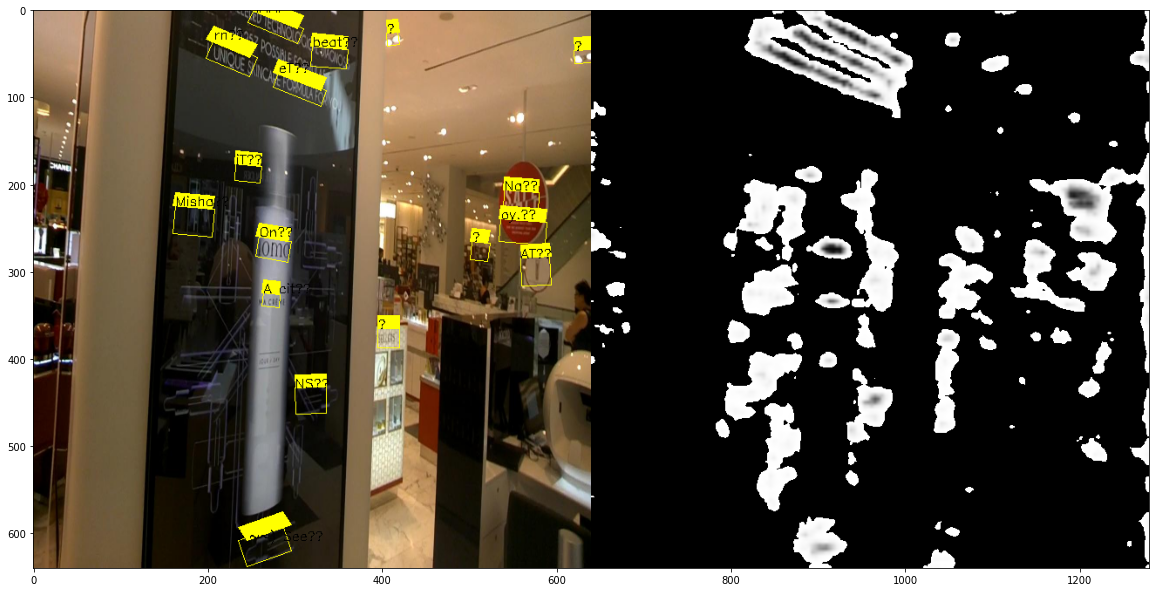

In [61]:
ds='icdar'
test_function1(ds)

**Test with custom image:**

input: (640, 640, 3)


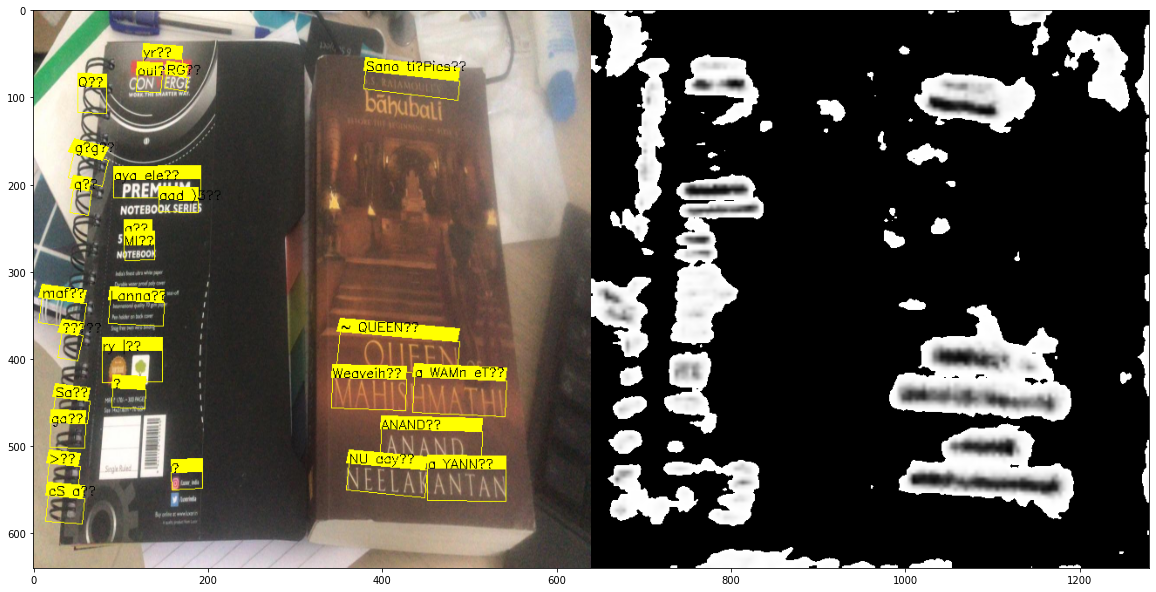

In [63]:
###########################################################
#
# params:
# init -> cpkt_dir='checkpoints/',load_models = True,input_shape = [640, 640, 3]
# call -> path,flag=1,video_flag=0,tes=0,plot=False
#  for ploting ROI,please uncomment plt in if(tes==1) loop.
#######################################################
path="real3.jpg"
detecttest=test_model()
recognition=detecttest(path,flag=0,plot=False,tes=1)